# Импорт необходимых библиотек

In [ ]:
!pip install --upgrade sktime[all_extras]

import sktime
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sktime.forecasting.model_selection import temporal_train_test_split, ExpandingWindowSplitter, SlidingWindowSplitter
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanSquaredError
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.tbats import TBATS

smape = MeanAbsolutePercentageError(symmetric=True)
rmse = MeanSquaredError(square_root=True)

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

r2_score = lambda y_pred, y_test: 1 - np.sum(np.square(y_pred - y_test)) / np.sum(np.square(y_test - np.mean(y_test)))

warnings.simplefilter("ignore", FutureWarning)
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.0/745.0 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 8.3 MB/s eta 0:00:00
     ━━━

In [ ]:
import seaborn as sns
sns.set_style('white')
sns.set(rc={'figure.figsize':(11, 4)})

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.arch import ARCH
from sktime.forecasting.arima import AutoARIMA

In [ ]:
import statsmodels.api as sm

# Загрузка данных в Pandas

In [ ]:
# Download hourly data from OPSD website
url = 'https://data.open-power-system-data.org/time_series/2020-10-06/'
datafile = url + 'time_series_60min_singleindex.csv'
df_all = pd.read_csv(datafile, index_col='utc_timestamp', parse_dates=True, low_memory=False)
df_all.head()

cet_cest_timestamp  \
utc_timestamp                                         
2014-12-31 23:00:00+00:00  2015-01-01T00:00:00+0100   
2015-01-01 00:00:00+00:00  2015-01-01T01:00:00+0100   
2015-01-01 01:00:00+00:00  2015-01-01T02:00:00+0100   
2015-01-01 02:00:00+00:00  2015-01-01T03:00:00+0100   
2015-01-01 03:00:00+00:00  2015-01-01T04:00:00+0100   

                           AT_load_actual_entsoe_transparency  \
utc_timestamp                                                   
2014-12-31 23:00:00+00:00                                 NaN   
2015-01-01 00:00:00+00:00                              5946.0   
2015-01-01 01:00:00+00:00                              5726.0   
2015-01-01 02:00:00+00:00                              5347.0   
2015-01-01 03:00:00+00:00                              5249.0   

                           AT_load_forecast_entsoe_transparency  \
utc_timestamp                                                     
2014-12-31 23:00:00+00:00                                   NaN   
2015-01-01 00:00:00+00:00                                6701.0   
2015-01-01 01:00:00+00:00                                6593.0   
2015-01-01 02:00:00+00:00                                6482.0   
2015-01-01 03:00:00+00:00                                6454.0   

                           AT_price_day_ahead  AT_solar_generation_actual  \
utc_timestamp                                                               
2014-12-31 23:00:00+00:00                 NaN                         NaN   
2015-01-01 00:00:00+00:00                35.0                         NaN   
2015-01-01 01:00:00+00:00                45.0                         NaN   
2015-01-01 02:00:00+00:00                41.0                         NaN   
2015-01-01 03:00:00+00:00                38.0                         NaN   

                           AT_wind_onshore_generation_actual  \
utc_timestamp                                                  
2014-12-31 23:00:00+00:00                                NaN   
2015-01-01 00:00:00+00:00                               69.0   
2015-01-01 01:00:00+00:00                               64.0   
2015-01-01 02:00:00+00:00                               65.0   
2015-01-01 03:00:00+00:00                               64.0   

                           BE_load_actual_entsoe_transparency  \
utc_timestamp                                                   
2014-12-31 23:00:00+00:00                                 NaN   
2015-01-01 00:00:00+00:00                              9484.0   
2015-01-01 01:00:00+00:00                              9152.0   
2015-01-01 02:00:00+00:00                              8799.0   
2015-01-01 03:00:00+00:00                              8567.0   

                           BE_load_forecast_entsoe_transparency  \
utc_timestamp                                                     
2014-12-31 23:00:00+00:00                                   NaN   
2015-01-01 00:00:00+00:00                                9897.0   
2015-01-01 01:00:00+00:00                                9521.0   
2015-01-01 02:00:00+00:00                                9135.0   
2015-01-01 03:00:00+00:00                                8909.0   

                           BE_solar_generation_actual  \
utc_timestamp                                           
2014-12-31 23:00:00+00:00                         NaN   
2015-01-01 00:00:00+00:00                         NaN   
2015-01-01 01:00:00+00:00                         NaN   
2015-01-01 02:00:00+00:00                         NaN   
2015-01-01 03:00:00+00:00                         NaN   

                           BE_wind_generation_actual  ...  \
utc_timestamp                                         ...   
2014-12-31 23:00:00+00:00                        NaN  ...   
2015-01-01 00:00:00+00:00                        NaN  ...   
2015-01-01 01:00:00+00:00                     734.81  ...   
2015-01-01 02:00:00+00:00                     766.64  ...   
2015-01-01 03:00:00+00:00               

Выведем список всех стран

In [ ]:
def extract_country(df_all, country_code, year_min=None, year_max=None):
    """Extract data for a single country"""

    # List of columns to extract
    columns = [col for col in df_all.columns if col.startswith(country_code)]

    # Extract columns and remove country codes from column labels
    columns_map = {col : col[7:] for col in columns}
    df_out = df_all[columns].rename(columns=columns_map)

    # Exclude years outside of specified range, if any
    if year_min is not None:
        df_out = df_out[df_out.index.year >= year_min]
    if year_max is not None:
        df_out = df_out[df_out.index.year <= year_max]

    return df_out

In [ ]:
df_hrly = extract_country(df_all, country_code='GB_GBN', year_min=2015, year_max=2019)
df_hrly.head()

load_actual_entsoe_transparency  \
utc_timestamp                                                
2015-01-01 00:00:00+00:00                          26758.0   
2015-01-01 01:00:00+00:00                          27166.0   
2015-01-01 02:00:00+00:00                          24472.0   
2015-01-01 03:00:00+00:00                          23003.0   
2015-01-01 04:00:00+00:00                          21832.0   

                           load_forecast_entsoe_transparency  price_day_ahead  \
utc_timestamp                                                                   
2015-01-01 00:00:00+00:00                            32057.0              NaN   
2015-01-01 01:00:00+00:00                            31738.0              NaN   
2015-01-01 02:00:00+00:00                            30690.0              NaN   
2015-01-01 03:00:00+00:00                            28442.0              NaN   
2015-01-01 04:00:00+00:00                            25978.0              NaN   

                           solar_capacity  solar_generation_actual  \
utc_timestamp                                                        
2015-01-01 00:00:00+00:00          2669.0                      NaN   
2015-01-01 01:00:00+00:00          2669.0                      NaN   
2015-01-01 02:00:00+00:00          2669.0                      NaN   
2015-01-01 03:00:00+00:00          2669.0                      NaN   
2015-01-01 04:00:00+00:00          2669.0                      NaN   

                           solar_profile  wind_capacity  \
utc_timestamp                                             
2015-01-01 00:00:00+00:00            NaN        11555.0   
2015-01-01 01:00:00+00:00            NaN        11555.0   
2015-01-01 02:00:00+00:00            NaN        11555.0   
2015-01-01 03:00:00+00:00            NaN        11555.0   
2015-01-01 04:00:00+00:00            NaN        11555.0   

                           wind_generation_actual  wind_profile  \
utc_timestamp                                                     
2015-01-01 00:00:00+00:00                     NaN           NaN   
2015-01-01 01:00:00+00:00                   782.0        0.0676   
2015-01-01 02:00:00+00:00                   785.0        0.0680   
2015-01-01 03:00:00+00:00                   776.0        0.0672   
2015-01-01 04:00:00+00:00                   773.0        0.0669   

                           wind_offshore_capacity  \
utc_timestamp                                       
2015-01-01 00:00:00+00:00                  4040.0   
2015-01-01 01:00:00+00:00                  4040.0   
2015-01-01 02:00:00+00:00                  4040.0   
2015-01-01 03:00:00+00:00                  4040.0   
2015-01-01 04:00:00+00:00                  4040.0   

                           wind_offshore_generation_actual  \
utc_timestamp                                                
2015-01-01 00:00:00+00:00                              NaN   
2015-01-01 01:00:00+00:00                            117.0   
2015-01-01 02:00:00+00:00                            120.0   
2015-01-01 03:00:00+00:00                            115.0   
2015-01-01 04:00:00+00:00                            114.0   

                           wind_offshore_profile  wind_onshore_capacity  \
utc_timestamp                                                             
2015-01-01 00:00:00+00:00                    NaN                 7516.0   
2015-01-01 01:00:00+00:00                 0.0290                 7516.0   
2015-01-01 02:00:00+00:00                 0.0296                 7516.0   
2015-01-01 03:00:00+00:00                 0.0284                 7516.0   
2015-01-01 04:00:00+00:00                 0.0281                 7516.0   

                           wind_onshore_generation_actual  \
utc_timestamp                                               
2015-01-01 00:00:00+00:00                             NaN   
2015-01-01 01:00:00+00:00                           664.0   
2015-01-01 02:00:00+00:00                           666.0   
2015-01-01 

In [ ]:
def transform_dataframe(df, cols_map):
    # Rename columns for convenience
    df = df[list(cols_map.keys())].rename(columns=cols_map)
    # Convert from MW to GW
    df = df / 1000
    df = df.resample('D').sum(min_count=24)
    df = df.rename_axis('Date')
    df.index = df.index.strftime('%Y-%m-%d')
    return df

In [ ]:
cols_map = {'load_actual_entsoe_transparency' : 'Consumption',
            'wind_generation_actual' : 'Wind',
            'solar_generation_actual' : 'Solar'}
df_daily = transform_dataframe(df_hrly, cols_map)

# Compute wind + solar generation
df_daily['Wind+Solar'] = df_daily[['Wind', 'Solar']].sum(axis=1, skipna=False)
df_daily.to_csv('de_data.csv')
df_daily.head()

Consumption    Wind  Solar  Wind+Solar
Date                                              
2015-01-01      679.307     NaN    NaN         NaN
2015-01-02      740.544  19.998  3.834      23.832
2015-01-03      744.237   8.487  1.026       9.513
2015-01-04      742.192   5.860  2.711       8.571
2015-01-05      997.524  82.669  2.035      84.704

# Анализ набора данных
Набор представляет собой ежедневное потребление электричества (в гига-Ваттах в час) в **Англии**. Набор включает следующие временные ряды в виде колонок:
* Date — дата в формате гггг-мм-дд;
* Consumption — Общее потребление, ГВт/ч;
* Wind — Потребление ветряной энергии, ГВт/ч;
* Solar — Потребление солнечной энергии, ГВт/ч;
* Wind+Solar — Потребление энергии из альтернативных источников, ГВт/ч.

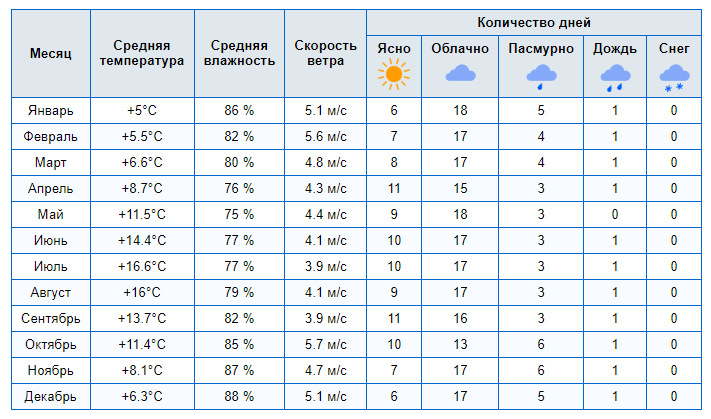

Таблица Средних показаний о погоде, собранные с 2014 года в Англии. [Ссылка на источник](http://weatherarchive.ru/Pogoda/UK)

## Общая информация по ряду

In [ ]:
path_ts = 'de_data.csv'

df = pd.read_csv(path_ts, parse_dates=['Date'], index_col="Date")

df.sample(5, random_state=0)

Consumption     Wind   Solar  Wind+Solar
Date                                                
2017-03-04      867.057  100.280  25.454     125.734
2017-02-28      994.848   99.614  22.787     122.401
2015-04-29      914.112  104.041  32.512     136.553
2015-11-15      855.842  186.597   5.007     191.604
2017-06-10      700.917  138.609  39.247     177.856

In [ ]:
df.iloc[0]

Consumption    679.307
Wind               NaN
Solar              NaN
Wind+Solar         NaN
Name: 2015-01-01 00:00:00, dtype: float64

In [ ]:
df.iloc[-1]

Consumption    846.991
Wind            86.762
Solar            5.259
Wind+Solar      92.021
Name: 2019-12-31 00:00:00, dtype: float64

In [ ]:
df.shape

(1826, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2015-01-01 to 2019-12-31
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  1824 non-null   float64
 1   Wind         1816 non-null   float64
 2   Solar        1816 non-null   float64
 3   Wind+Solar   1816 non-null   float64
dtypes: float64(4)
memory usage: 71.3 KB


In [ ]:
df.describe()

Consumption         Wind        Solar   Wind+Solar
count  1824.000000  1816.000000  1816.000000  1816.000000
mean    852.570230   103.605937    27.108445   130.714382
std     100.415716    56.195037    18.107707    52.707597
min     476.203000     5.088000     0.690000     8.571000
25%     777.801750    57.585500    11.387000    89.521750
50%     844.912000    96.094500    24.708500   125.622000
75%     925.793250   144.365750    40.193500   166.878000
max    1121.540000   280.527000    77.744000   296.640000

In [ ]:
df.dtypes

Consumption    float64
Wind           float64
Solar          float64
Wind+Solar     float64
dtype: object

In [ ]:
df.isna().sum()

Consumption     2
Wind           10
Solar          10
Wind+Solar     10
dtype: int64

In [ ]:
df[df.Consumption.isna() == True]

Consumption    Wind  Solar  Wind+Solar
Date                                              
2015-03-29          NaN  128.98  9.761     138.741
2017-03-26          NaN     NaN    NaN         NaN

In [ ]:
df[df.Wind.isna() == True]

Consumption  Wind  Solar  Wind+Solar
Date                                            
2015-01-01      679.307   NaN    NaN         NaN
2015-05-13      874.613   NaN    NaN         NaN
2017-03-26          NaN   NaN    NaN         NaN
2017-08-22      805.555   NaN    NaN         NaN
2017-08-26      709.512   NaN    NaN         NaN
2017-08-27      682.177   NaN    NaN         NaN
2017-09-02      715.359   NaN    NaN         NaN
2017-11-02      846.461   NaN    NaN         NaN
2017-11-03      812.903   NaN    NaN         NaN
2017-11-15      844.309   NaN    NaN         NaN

In [ ]:
df[df.Solar.isna() == True]

Consumption  Wind  Solar  Wind+Solar
Date                                            
2015-01-01      679.307   NaN    NaN         NaN
2015-05-13      874.613   NaN    NaN         NaN
2017-03-26          NaN   NaN    NaN         NaN
2017-08-22      805.555   NaN    NaN         NaN
2017-08-26      709.512   NaN    NaN         NaN
2017-08-27      682.177   NaN    NaN         NaN
2017-09-02      715.359   NaN    NaN         NaN
2017-11-02      846.461   NaN    NaN         NaN
2017-11-03      812.903   NaN    NaN         NaN
2017-11-15      844.309   NaN    NaN         NaN

In [ ]:
#df_hrly.fillna(0, inplace=True) # Замена на ну левые значения
df.interpolate(inplace=True) # Интерполяция на соседние значения
df.head(3)

Consumption    Wind  Solar  Wind+Solar
Date                                              
2015-01-01      679.307     NaN    NaN         NaN
2015-01-02      740.544  19.998  3.834      23.832
2015-01-03      744.237   8.487  1.026       9.513

In [ ]:
df.isna().sum()

Consumption    0
Wind           1
Solar          1
Wind+Solar     1
dtype: int64

Может быть стоит пропуски заполнять средним, а потом итерполировать

In [ ]:
#Данные можно представлять с нужной частотой при помощи метода asfreq, например с частотой D - день, W,M,Y для недели, месяца и года соответственно.
#df[['Wind']].loc['2015-10-20':'2015-12-25'].asfreq('W')

## Визуализация временного ряда


<Axes: xlabel='Date'>

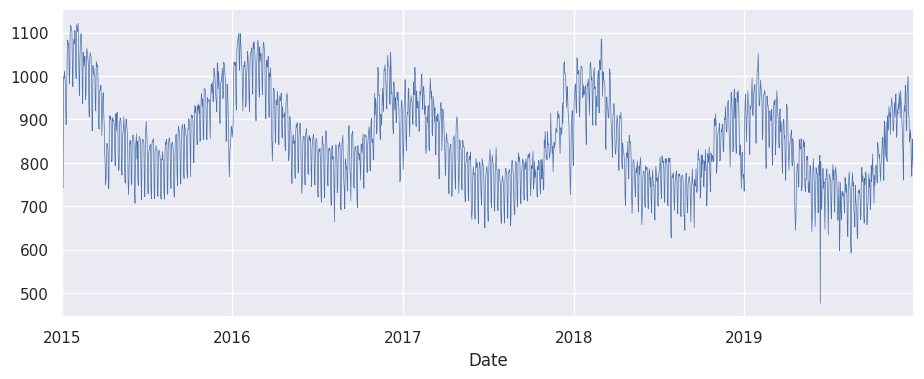

In [ ]:
df['Consumption'].plot(linewidth=0.5)

Визуально наблюдаем наличие годовой сезонности и убывающего тренда

In [ ]:
df['Traditional'] = df['Consumption'] - df['Solar'] - df['Wind']

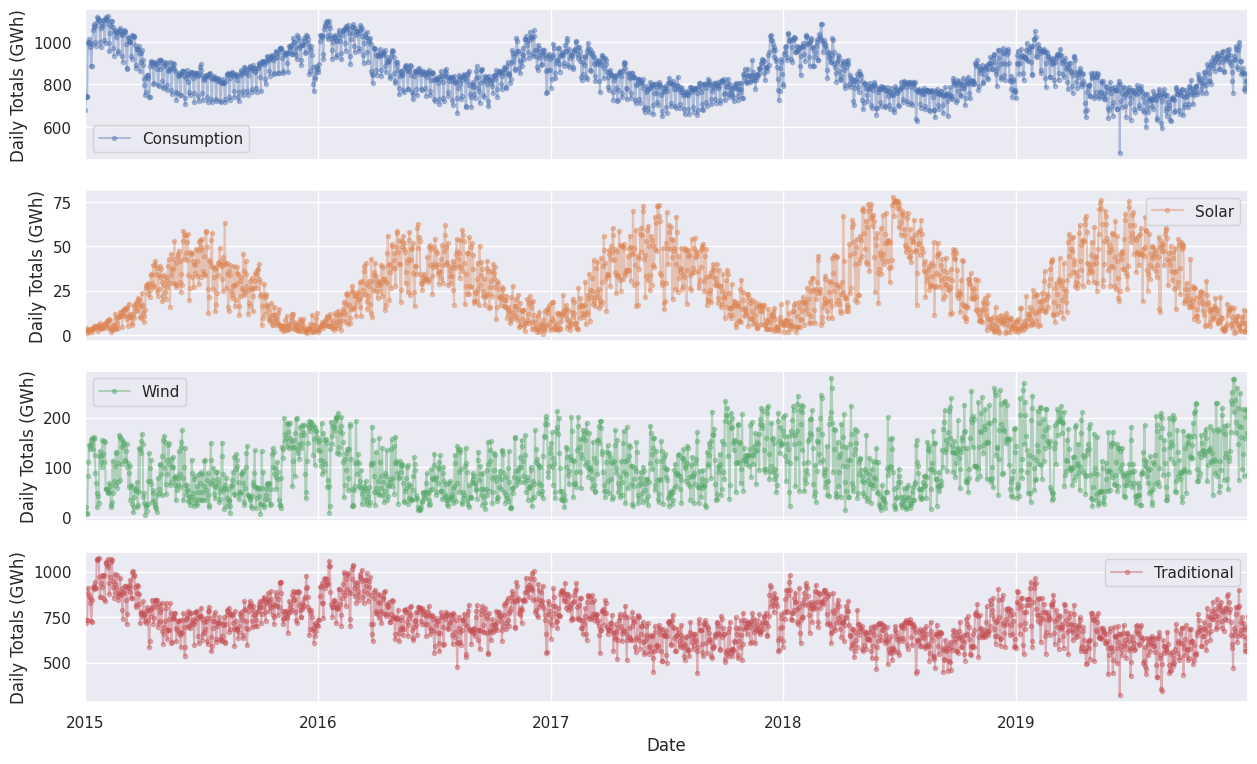

In [ ]:
cols_plot = ['Consumption', 'Solar', 'Wind','Traditional']
axes = df[cols_plot].plot(marker='.', alpha=0.4, linestyle='-', figsize=(15, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (GWh)')

Имеем наличие сезонности от времени года у всех трех источников, а также явный убывающий тренд в потреблении из Традиционных источников и растущие тренды у не традиционных источников.

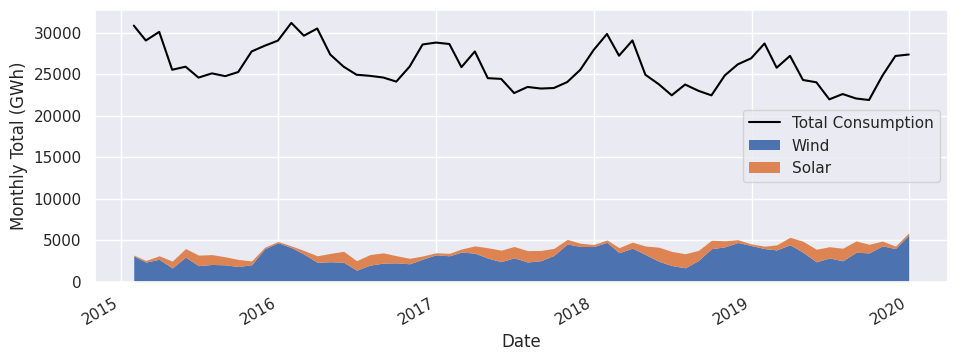

In [ ]:
df_monthly = df.resample('M').sum(min_count=7)

fig, ax = plt.subplots()
ax.plot(df_monthly['Consumption'], color='black', label='Total Consumption')

df_monthly[['Wind', 'Solar']].plot.area(ax=ax, linewidth=0)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_ylabel('Monthly Total (GWh)');

## Анализ общего потребления

<Axes: xlabel='Date'>

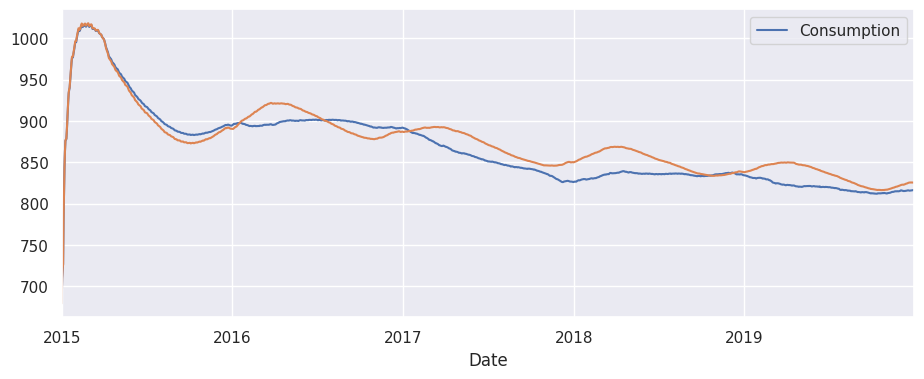

In [ ]:
df[['Consumption']].rolling('365d').mean().plot( linewidth=1.5, );
df.Consumption.ewm(halflife=365, min_periods=0,adjust=True).mean().plot()

Распределение значений

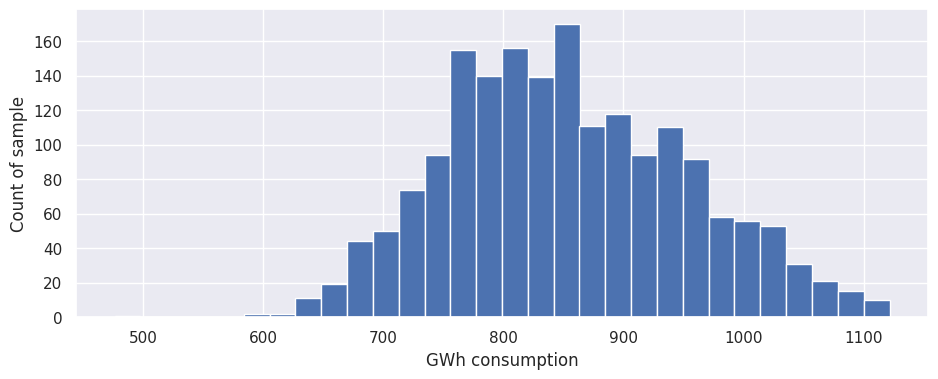

In [ ]:
ax = df.Consumption.hist(bins=30)
ax.set_ylabel('Count of sample')
ax.set_xlabel('GWh consumption')
plt.show()

В распределении мы видим две составляющих, предположительно соответствующих двум периодам в данных. Пики этих составляющих приходятся на 800 и 900 ГВт.

Построим график потребления для периода в 2 месяца, включая начала и конец года. И Рассмотрим спад в соотвествии с выходными. Ноябрь 2016 - Январь 2017

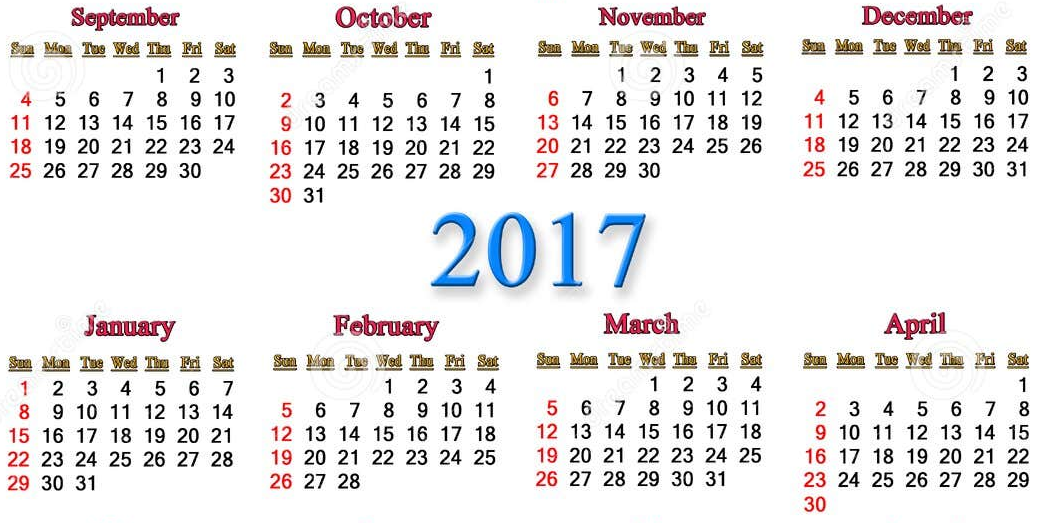

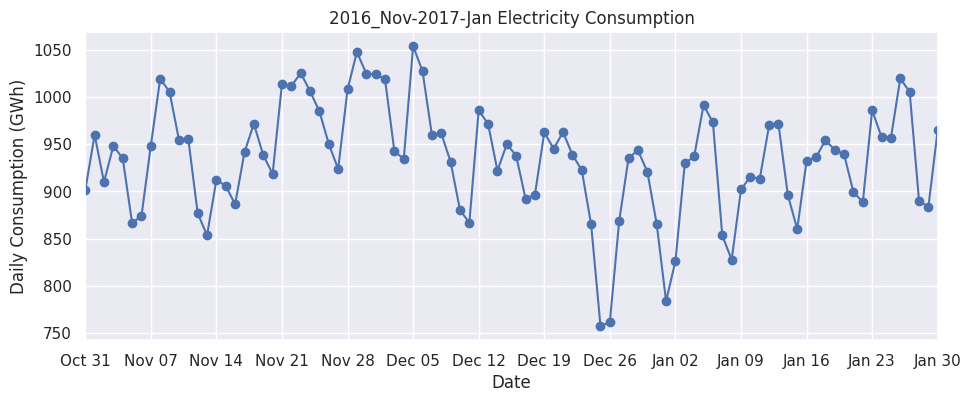

In [ ]:
ax = df.loc['2016-10-31':'2017-01-30', 'Consumption'].plot(marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption (GWh)')
ax.set_title('2016_Nov-2017-Jan Electricity Consumption')
# For more convinient ticks (week ticks)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
# Format 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.show()

Спад потребления приходится на выходные, а также возможно на третью компоненту - праздничные дни (25, 26 декабря, Рождество, протенстанский День подарков соответственно) и празднование нового года.

Рост приходится на начало рабочей недели

Проверим гипотезу о третьей компоненте.

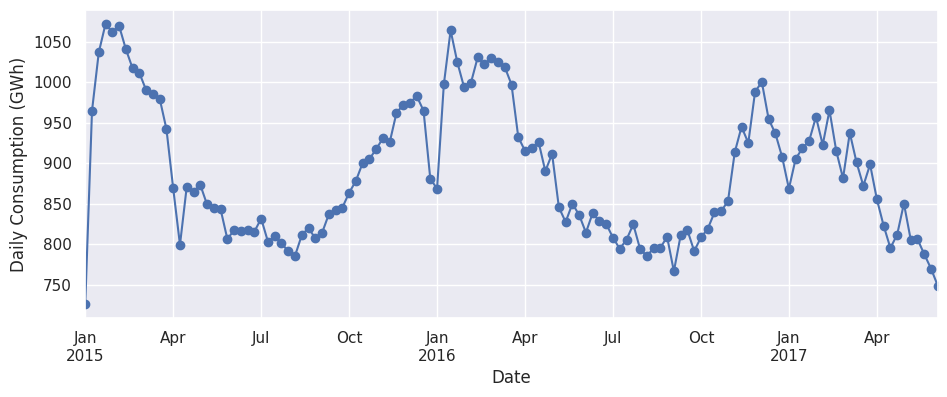

In [ ]:
ax = df.loc['2013-10':'2017-05', 'Consumption'].\
    resample('W').mean().plot(marker='o', linestyle='-',linewidth=1.5)
ax.set_ylabel('Daily Consumption (GWh)')
plt.show()

Похоже, что гипотеза о третьей компоненте имеет место быть

## Анализ потребления из солнечных источников

<Axes: xlabel='Date'>

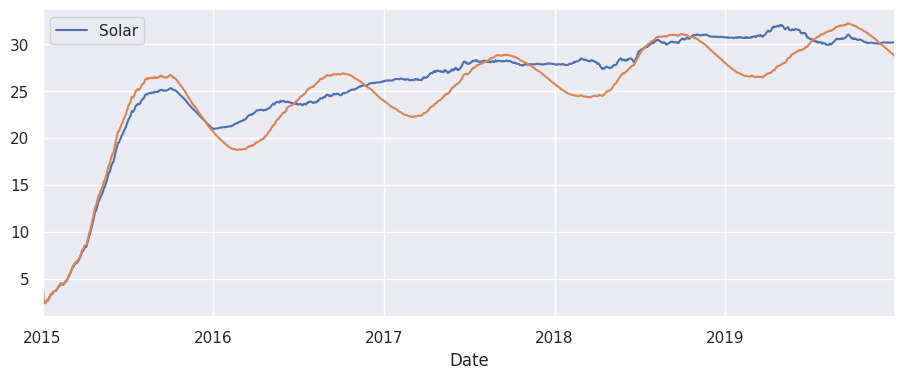

In [ ]:
df[['Solar']].rolling('365d').mean().plot( linewidth=1.5, );
df.Solar.ewm(halflife=365, min_periods=0,adjust=True).mean().plot()

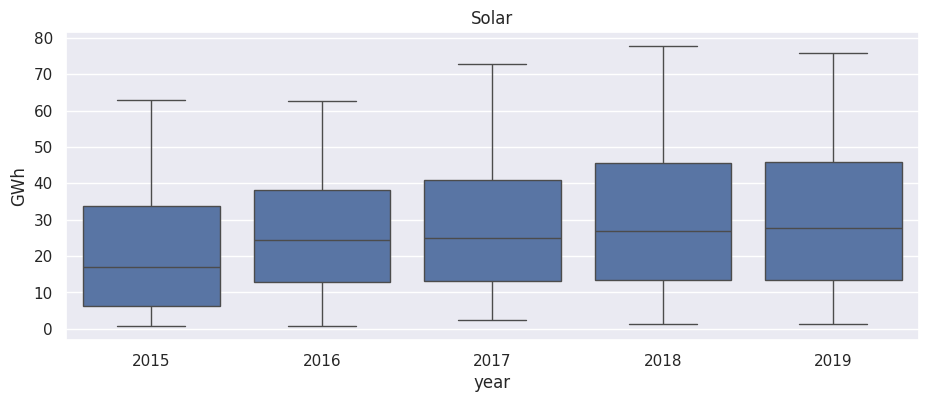

In [ ]:
ax = sns.boxplot(data=df, x=df.index.year, y='Solar')
ax.set_ylabel('GWh')
ax.set_xlabel('year')
ax.set_title('Solar')
plt.show()

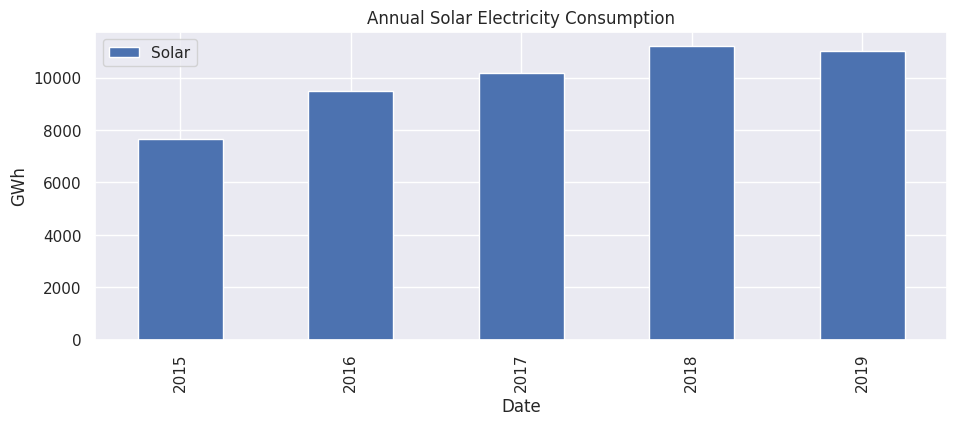

In [ ]:
df_test = df[['Solar']].resample('Y').sum()

ax = df_test.set_index(df_test.index.year).plot.bar()
ax.set_title('Annual Solar Electricity Consumption')
ax.set_ylabel('GWh');

Проверим наличие сезонности

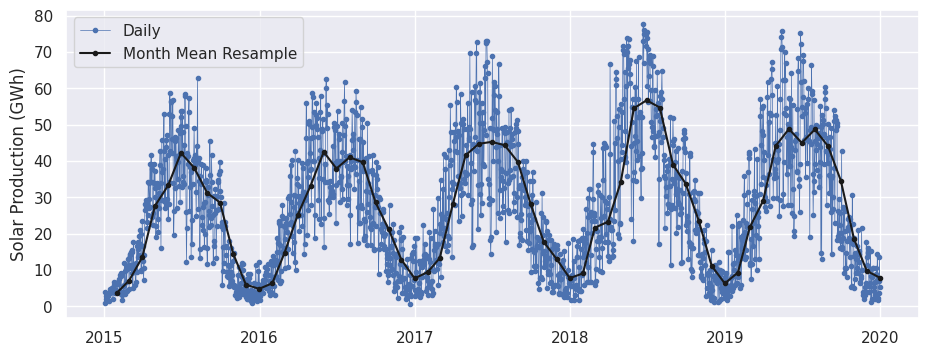

In [ ]:
start, end = '2015-01', '2019-12'

fig, ax = plt.subplots()
ax.plot(df.loc[start:end, 'Solar'],marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(df.resample('M').mean().loc[start:end, 'Solar'], marker='o', markersize=3, linestyle='-', label='Month Mean Resample', color='k')
ax.set_ylabel('Solar Production (GWh)')
ax.legend();

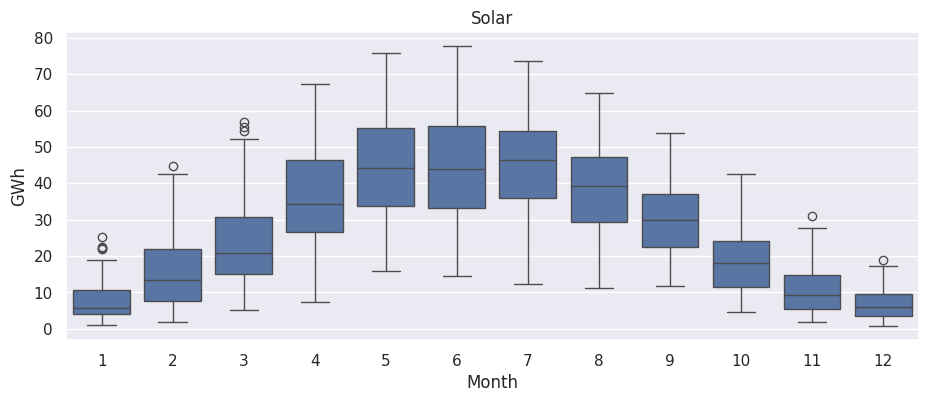

In [ ]:
ax = sns.boxplot(data=df, x=df.index.month, y='Solar')
ax.set_ylabel('GWh')
ax.set_xlabel('Month')
ax.set_title('Solar')
plt.show()

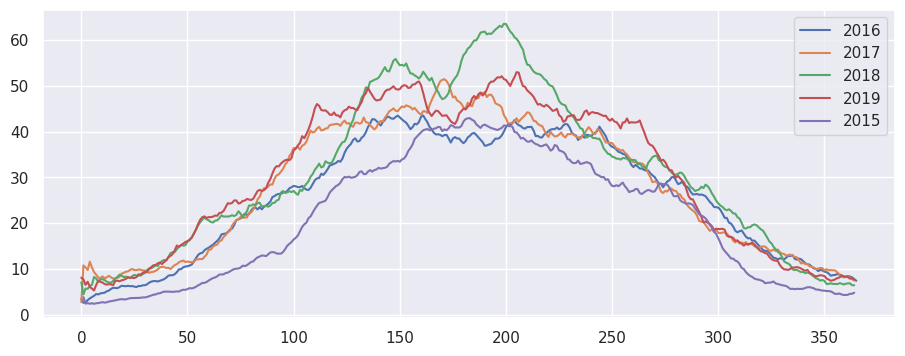

In [ ]:
for year in list(set(df.index.year)):
    plt.plot(df.loc[str(year):str(year), 'Solar'].rolling('30d').mean().values, label=year)
plt.legend()

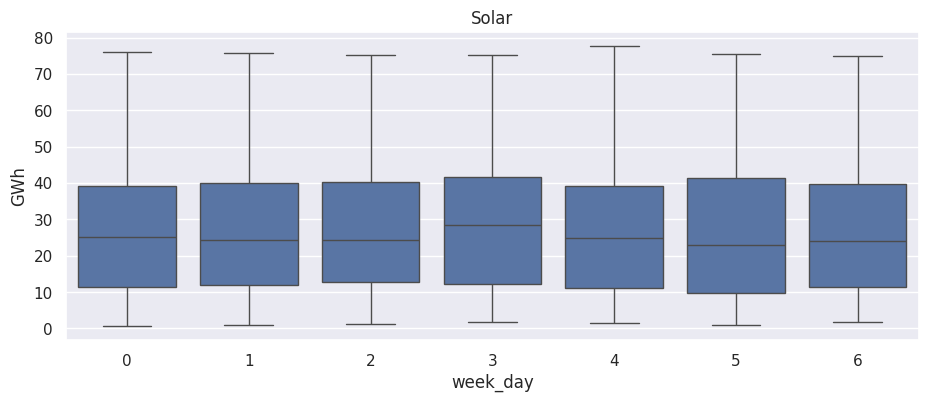

In [ ]:
ax = sns.boxplot(data=df, x=df.index.weekday, y='Solar');
ax.set_ylabel('GWh')
ax.set_xlabel('week_day')
ax.set_title('Solar')
plt.show()

## Анализ потребления из источников на основе ветра

<Axes: xlabel='Date'>

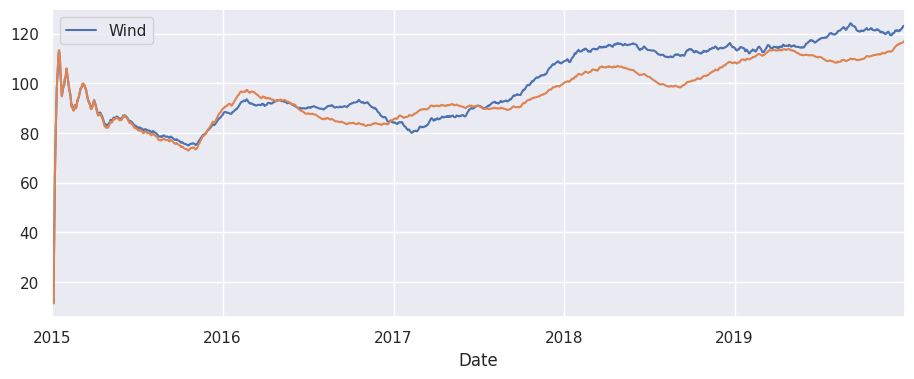

In [ ]:
df[['Wind']].rolling('365d').mean().plot( linewidth=1.5, );
df.Wind.ewm(halflife=365, min_periods=0,adjust=True).mean().plot()

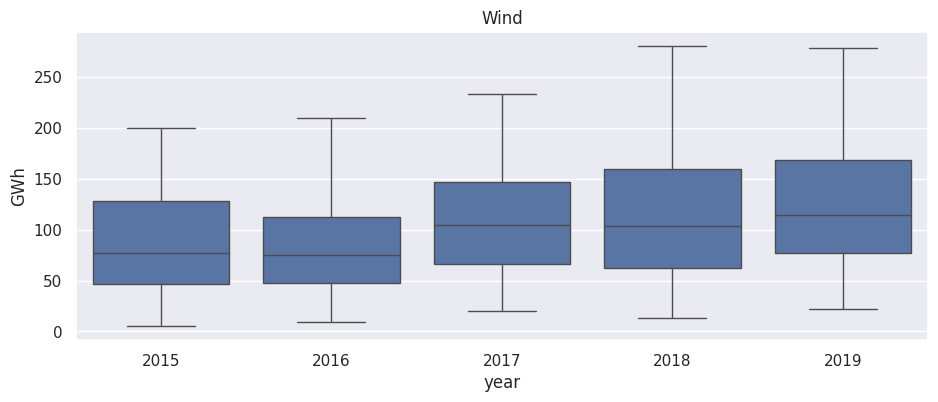

In [ ]:
ax = sns.boxplot(data=df, x=df.index.year, y='Wind')
ax.set_ylabel('GWh')
ax.set_xlabel('year')
ax.set_title('Wind')
plt.show()

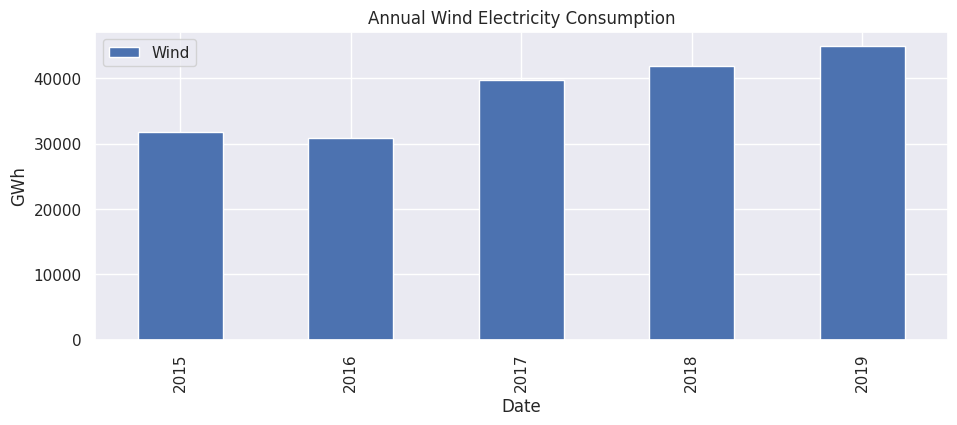

In [ ]:
df_test = df[['Wind']].resample('Y').sum()

ax = df_test.set_index(df_test.index.year).plot.bar()
ax.set_title('Annual Wind Electricity Consumption')
ax.set_ylabel('GWh');

Проверим наличие сезонности

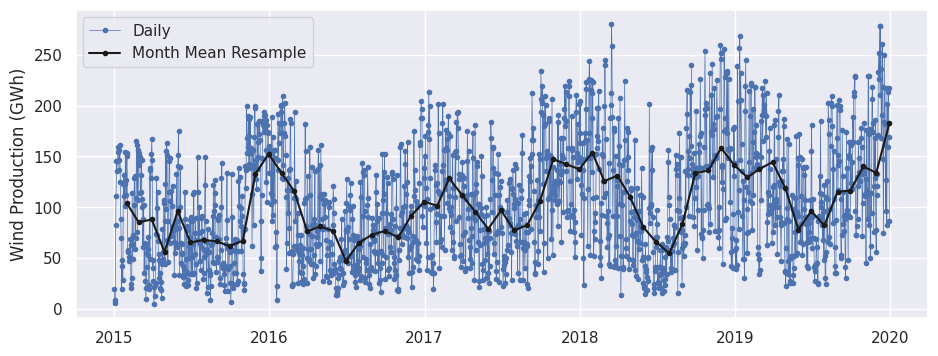

In [ ]:
start, end = '2015-01', '2019-12'

fig, ax = plt.subplots()
ax.plot(df.loc[start:end, 'Wind'],marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(df.resample('M').mean().loc[start:end, 'Wind'], marker='o', markersize=3, linestyle='-', label='Month Mean Resample', color='k')
ax.set_ylabel('Wind Production (GWh)')
ax.legend();

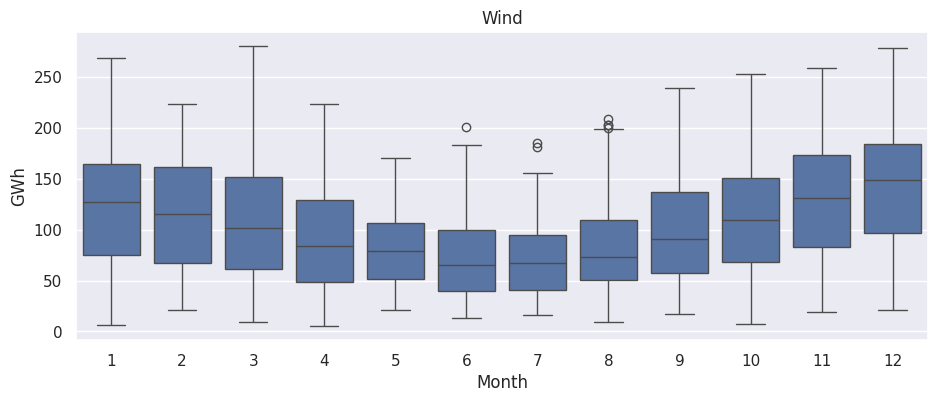

In [ ]:
ax = sns.boxplot(data=df, x=df.index.month, y='Wind')
ax.set_ylabel('GWh')
ax.set_xlabel('Month')
ax.set_title('Wind')
plt.show()

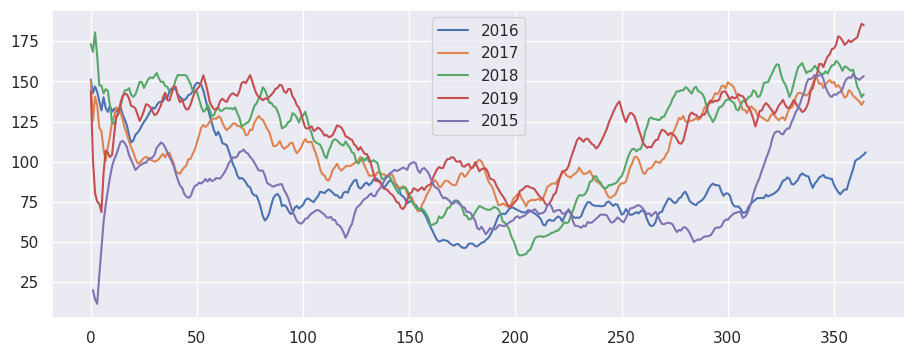

In [ ]:
for year in list(set(df.index.year)):
    plt.plot(df.loc[str(year):str(year), 'Wind'].rolling('30d').mean().values, label=year)
plt.legend()

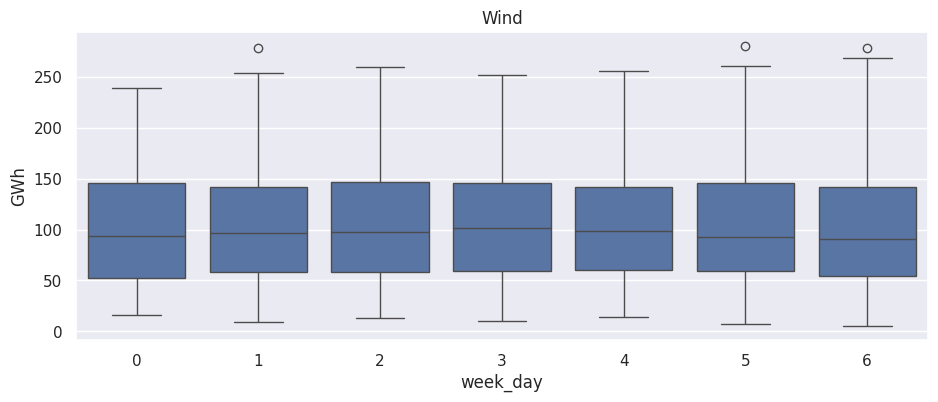

In [ ]:
ax = sns.boxplot(data=df, x=df.index.weekday, y='Wind');
ax.set_ylabel('GWh')
ax.set_xlabel('week_day')
ax.set_title('Wind')
plt.show()

## Анализ потребления из традиционных источников

<Axes: xlabel='Date'>

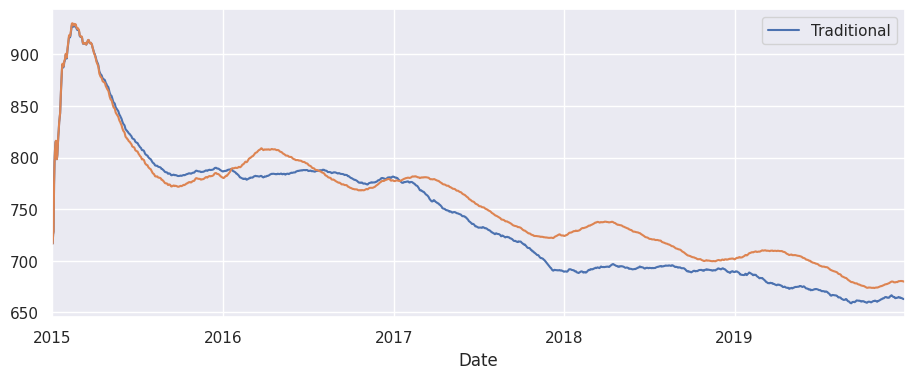

In [ ]:
df[['Traditional']].rolling('365d').mean().plot( linewidth=1.5, );
df.Traditional.ewm(halflife=365, min_periods=0,adjust=True).mean().plot()

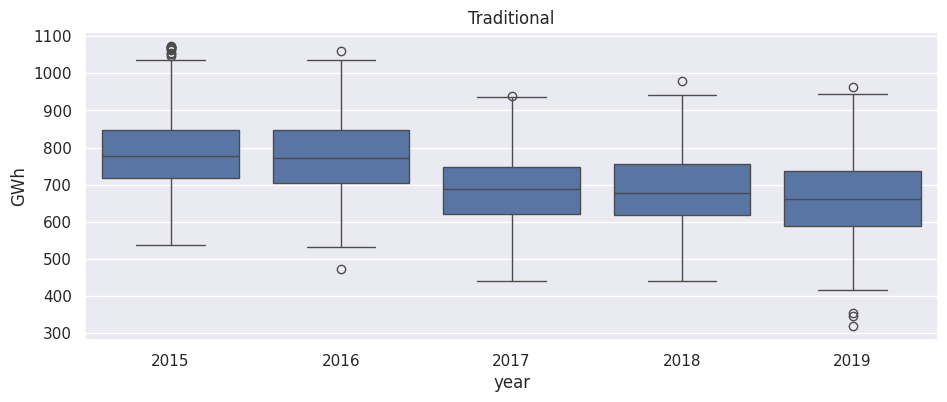

In [ ]:
ax = sns.boxplot(data=df, x=df.index.year, y='Traditional')
ax.set_ylabel('GWh')
ax.set_xlabel('year')
ax.set_title('Traditional')
plt.show()

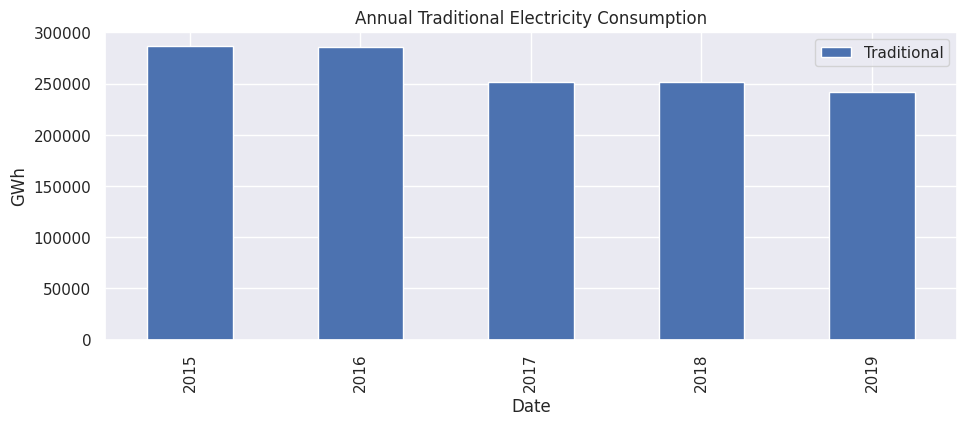

In [ ]:
df_test = df[['Traditional']].resample('Y').sum()

ax = df_test.set_index(df_test.index.year).plot.bar()
ax.set_title('Annual Traditional Electricity Consumption')
ax.set_ylabel('GWh');

Проверим наличие сезонности

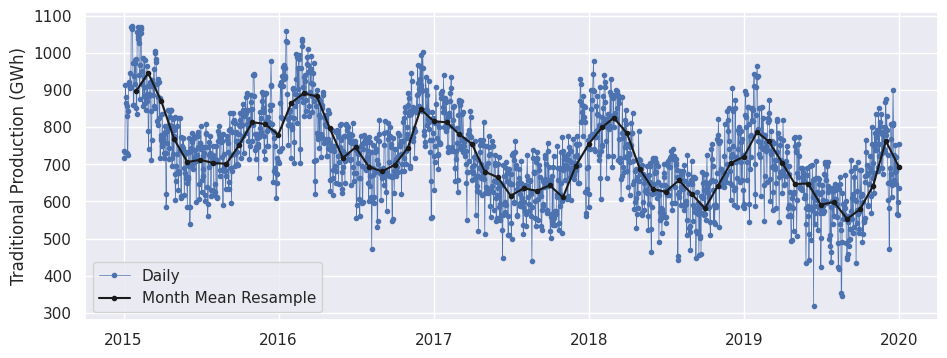

In [ ]:
start, end = '2015-01', '2019-12'

fig, ax = plt.subplots()
ax.plot(df.loc[start:end, 'Traditional'],marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(df.resample('M').mean().loc[start:end, 'Traditional'], marker='o', markersize=3, linestyle='-', label='Month Mean Resample', color='k')
ax.set_ylabel('Traditional Production (GWh)')
ax.legend();

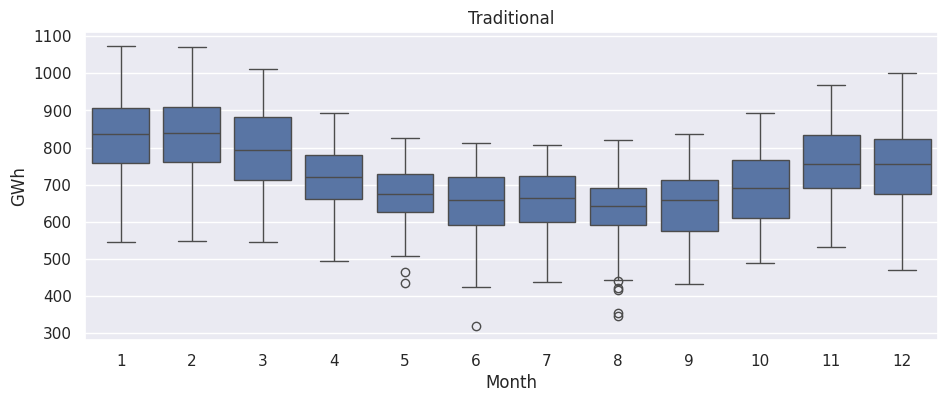

In [ ]:
ax = sns.boxplot(data=df, x=df.index.month, y='Traditional')
ax.set_ylabel('GWh')
ax.set_xlabel('Month')
ax.set_title('Traditional')
plt.show()

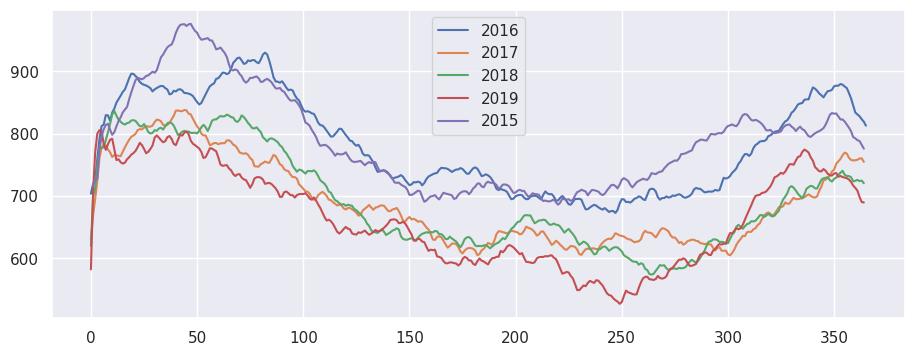

In [ ]:
for year in list(set(df.index.year)):
    plt.plot(df.loc[str(year):str(year), 'Traditional'].rolling('30d').mean().values, label=year)
plt.legend()

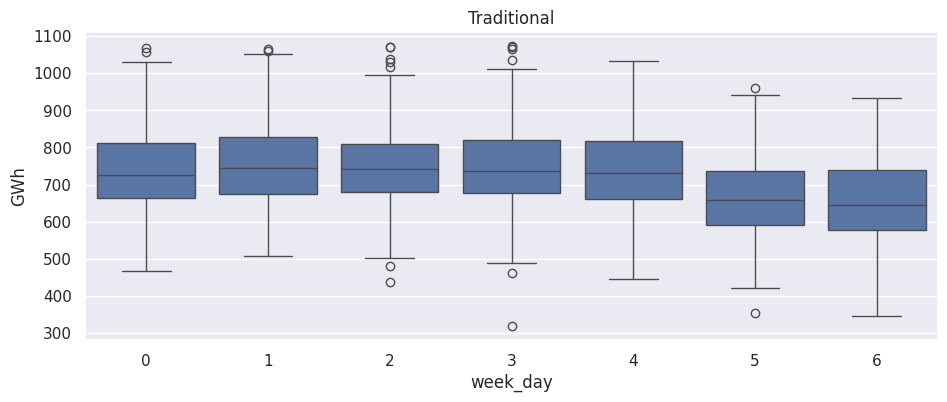

In [ ]:
ax = sns.boxplot(data=df, x=df.index.weekday, y='Traditional');
ax.set_ylabel('GWh')
ax.set_xlabel('week_day')
ax.set_title('Traditional')
plt.show()

## **Выводы:**

Исходя из представленной таблицы Средних показаний о погоде в Англии и графиков можно сделать вывод, что:

1) Потребление энергии из солнечных источников зависит от климатических особенностей расположения страны. Летом продолжительность светового дня увеличивается, что позволяет добывать больше энергии, а зимой возрастает количество осадков, что уменьшает добычу энергии.

* Тренд РАСТУЩИЙ, но похоже имеет тенденцию к затуханнию(насыщению);
* Сезонность имеет как минимум 2 компоненты(быструю, с периодом неделя и медленную с периодом 1 год);
* Не СТАЦИОНАРЕН Дисп. и Сред. уменьщаеются от года к году;

2) Потребление энергии из ветровых источников зависит от климатических особенностей расположения страны. Зимой ветра усиливаются, что увеличивает добычу энергии данного типа. Тренд РАСТУЩИЙ.

* Тренд РАСТУЩИЙ;
* Сезонность имеет как минимум 2 компоненты(быструю, с периодом неделя и медленную с периодом 1 год);
* Не СТАЦИОНАРЕН. Дисп. и Сред. увеличиваются от года к году;

3) Потребление энергии из традиционных источников возрастает в зимний период т.к. падает среднесуточная температура. Тренд УБЫВАЮЩИЙ, причиной этому может служить государственная политика "Постепенный отказ от традиционных источников электроэнергии".

* Тренд УБЫВАЮЩИЙ;
* Сезонность имеет как минимум 2 компоненты(быструю, с периодом неделя и медленную с периодом 1 год);
* Не СТАЦИОНАРЕН Дисп. и Сред. уменьщаеются от года к году;

**Убыль тренда традиционных истоников в данной задаче по всей видимости не компенсируется увеличением тренда Ветреных истоников, что может быть следствием либо сокрашение производства, либо наличием других источников электроэнергии не учтенных в задаче.**

**В Дальнейшем, в этой работе, будем расматривать только столбец по общим потреблениям.**

# Разбиение на тренировочную и тестовую выбору

In [ ]:
path_ts = 'de_data.csv'
df = pd.read_csv(path_ts, parse_dates=['Date'], index_col="Date")

In [ ]:
df=df.fillna(df.mean())

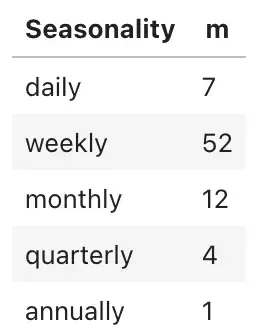

In [ ]:
y = df.Consumption.asfreq('7d')
y.head()

Date
2015-01-01     679.307
2015-01-08     995.378
2015-01-15    1071.180
2015-01-22    1104.892
2015-01-29    1104.959
Freq: 7D, Name: Consumption, dtype: float64

In [ ]:
SEASON = 52

In [ ]:
#TEST_SIZE = int(0.205*y.size) # Для того что бы Train/SEASON=0
TEST_SIZE = int(0.205*y.size) # Для того что бы Train/SEASON=0

y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)

print(f'Check splitted data size: Train: {y_train.shape[0]}, Test: {y_test.shape[0]}')

Check splitted data size: Train: 208, Test: 53


Визуализируем Тренировочную и тестовую выборку

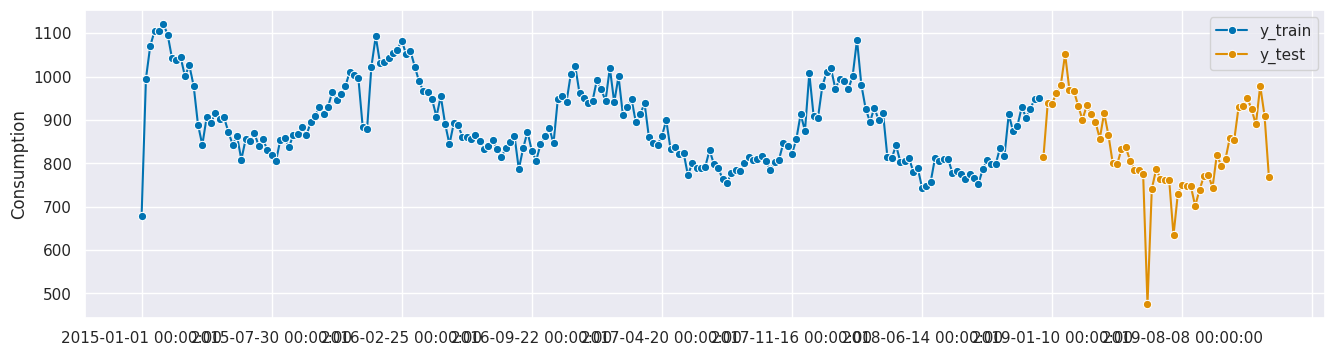

In [ ]:
sktime.utils.plotting.plot_series(y_train, y_test, labels=["y_train", "y_test"]);

 # Предсказания с использованием различных методов (метрика sMAPE)

Для прогноза воспользуемся моделями способными учитывать сезонность, работать с нестационарми рядами имеющими волотильность, попробуем использовать преобразования Бокса-Кокса, экспоненциальное сглаживание Холта-Виентерса

## Разложение для оценки Адаптивности и мультипликативности

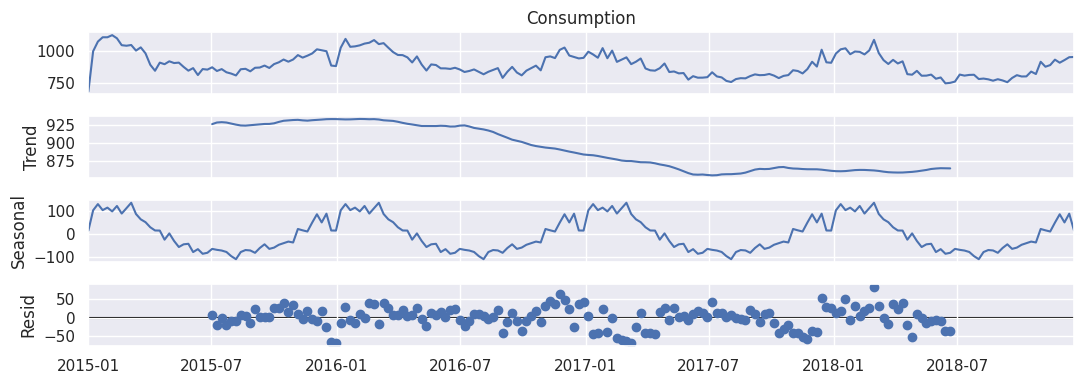

In [ ]:
result = seasonal_decompose(y_train, model='additive', period = SEASON)
result.plot();

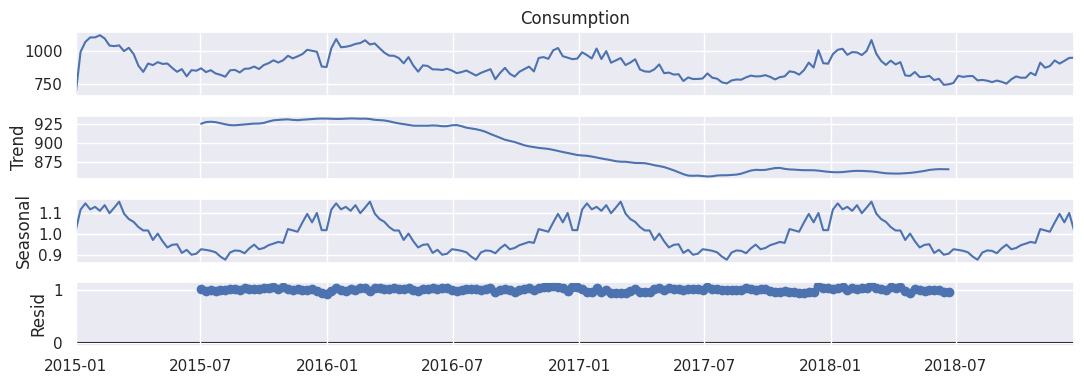

In [ ]:
result = seasonal_decompose(y_train, model='multiplicative', period = SEASON)
result.plot();

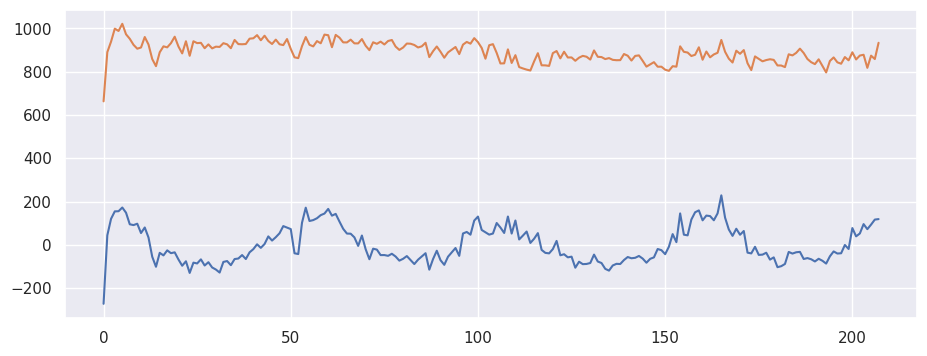

In [ ]:
detrend  = Detrender(forecaster=PolynomialTrendForecaster(degree=1))
plt.plot(detrend.fit_transform(y_train.values))
deseason = Deseasonalizer(model="additive", sp=52)
plt.plot(deseason.fit_transform(y_train.values))

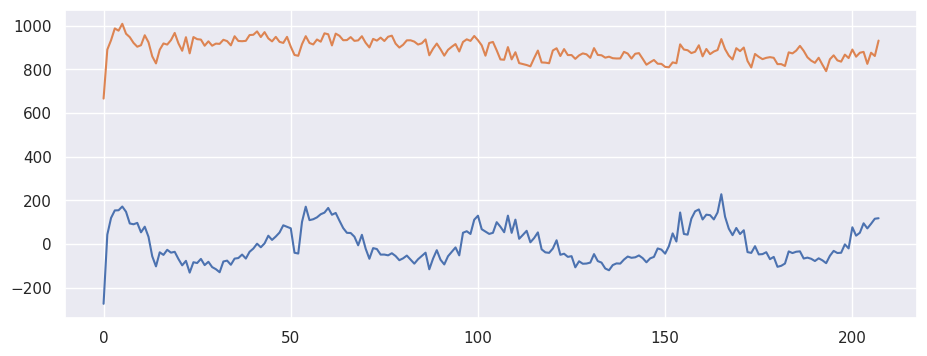

In [ ]:
detrend  = Detrender(forecaster=PolynomialTrendForecaster(degree=1))
plt.plot(detrend.fit_transform(y_train.values))
deseason = Deseasonalizer(model="multiplicative", sp=52)
plt.plot(deseason.fit_transform(y_train.values))

In [ ]:
# Perform ADF test for additive model
adf_result = sm.tsa.stattools.adfuller(y_train)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.9817645914275275
p-value: 0.0015090655773737911
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575


Поскольку p-значение меньше уровня значимости 0,05, мы отвергаем нулевую гипотезу, и ряд считается стационарным вокруг среднего значения.

In [ ]:
# Perform KPSS test for multiplicative model
kpss_result = sm.tsa.stattools.kpss(y_train)
print('KPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])
print('Critical Values:')
for key, value in kpss_result[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.4751912141020997
p-value: 0.04725423105808566
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


Поскольку p-значение больше уровня значимости 0,05, мы не можем отвергнуть нулевую гипотезу, и ряд считается стационарным вокруг детерминированного тренда.

## Горизонт предсказывания

sMAPE = 0.143


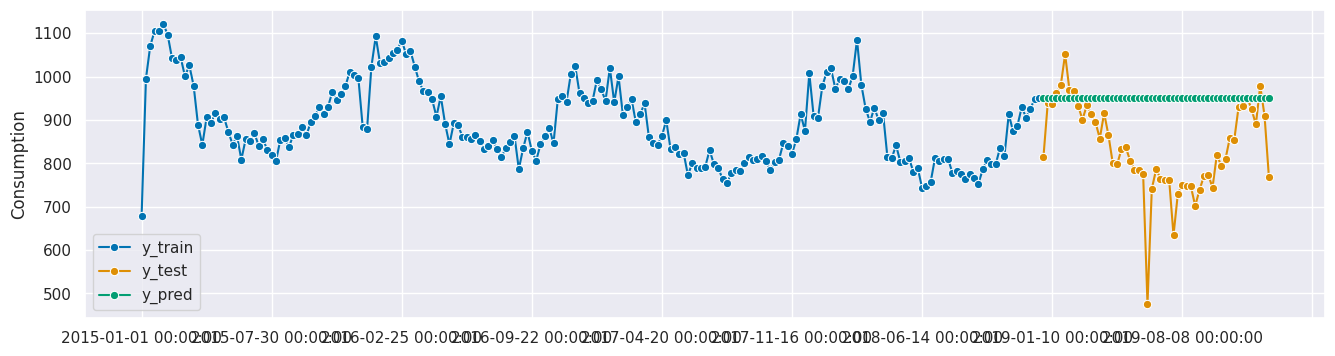

In [ ]:
# ГОРИЗОНТ
#fh = np.arange(y_test.size) + 1
fh = ForecastingHorizon(y_test.index, is_relative=False)

# ПРЕДСКАЗАТЕЛЬ
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)

# ПРЕДСКАЗАНИЕ
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# ОШИБКА
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

## Наивное сезонное предсказание

sMAPE = 0.073


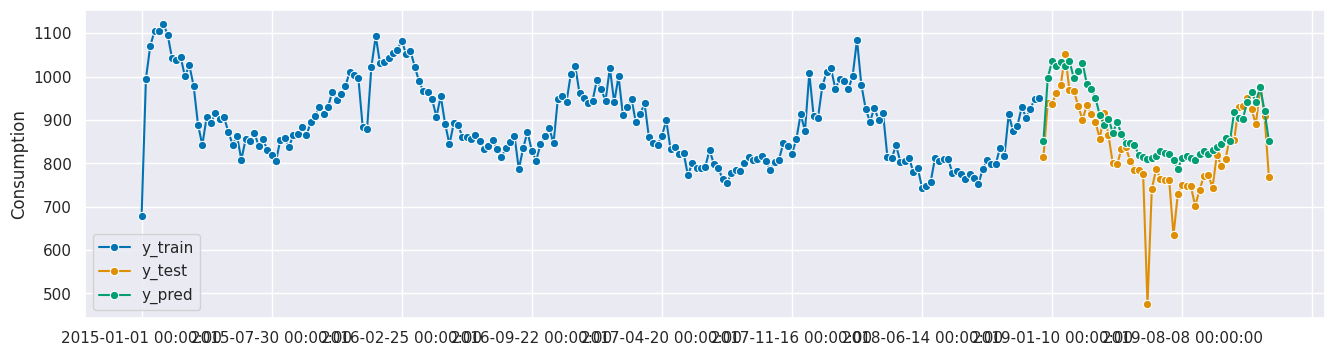

In [ ]:
forecaster = NaiveForecaster(strategy="mean", sp=SEASON)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

## Экспонициальное сглаживание

In [ ]:
# МЕТОДЫ
ses = ExponentialSmoothing(sp=SEASON)
holt_add = ExponentialSmoothing(trend="add", damped_trend=False,  sp=SEASON)
holt_mul = ExponentialSmoothing(trend="mul", damped_trend=False,  sp=SEASON)
damped_holt = ExponentialSmoothing(trend="add", damped_trend=True,   sp=SEASON)
holt_winter = ExponentialSmoothing(trend="add", seasonal="additive", sp=SEASON)
holt_winter_add_boxcox  = ExponentialSmoothing(trend="add", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_mul_boxcox  = ExponentialSmoothing(trend="mul", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_sadd_boxcox = ExponentialSmoothing(trend="add", seasonal="mul", use_boxcox =True, sp=SEASON)
holt_winter_smul_boxcox = ExponentialSmoothing(trend="mul", seasonal="mul", use_boxcox =True, sp=SEASON)

In [ ]:
# ПРЕДСКАЗАТЕЛЬ
forecaster = EnsembleForecaster(
    [
#        ("ses", ses),
#        ("holt_add", holt_add),
#        ("holt_mul", holt_mul),
#        ("damped", damped_holt),
#        ("holt-winter",holt_winter),
#        ("holt-winter, additive trend, box-cox", holt_winter_add_boxcox),
#        ("holt-winter, multiplicative trend, box-cox", holt_winter_mul_boxcox),
        ("holt-winter, additive season, box-cox", holt_winter_sadd_boxcox),
#        ("holt-winter, multiplicative both, box-cox", holt_winter_smul_boxcox)
    ]
)

sMAPE = 0.063


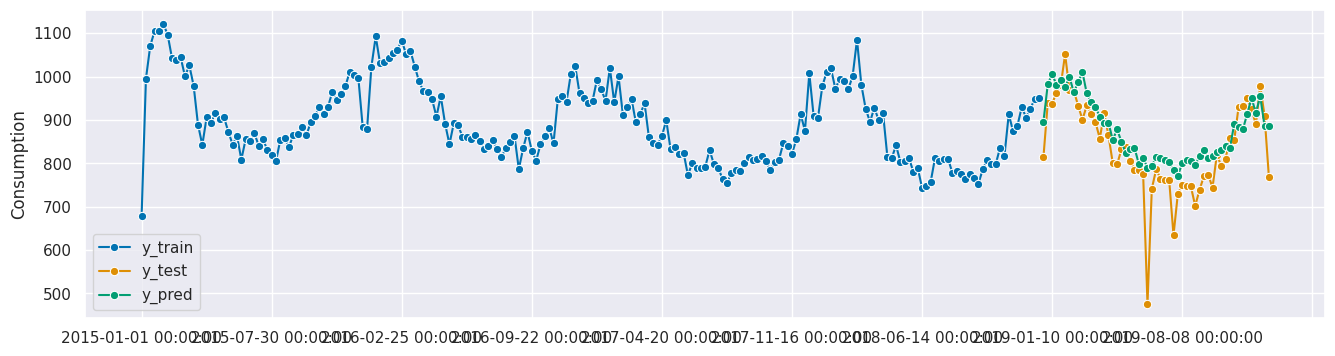

In [ ]:
forecaster.fit(y_train)

# ПРЕДСКАЗАНИЕ
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# РЕЗУЛЬТАТ
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

## Экспоненциальное сглаживания с использованием разложения

sMAPE = 0.080


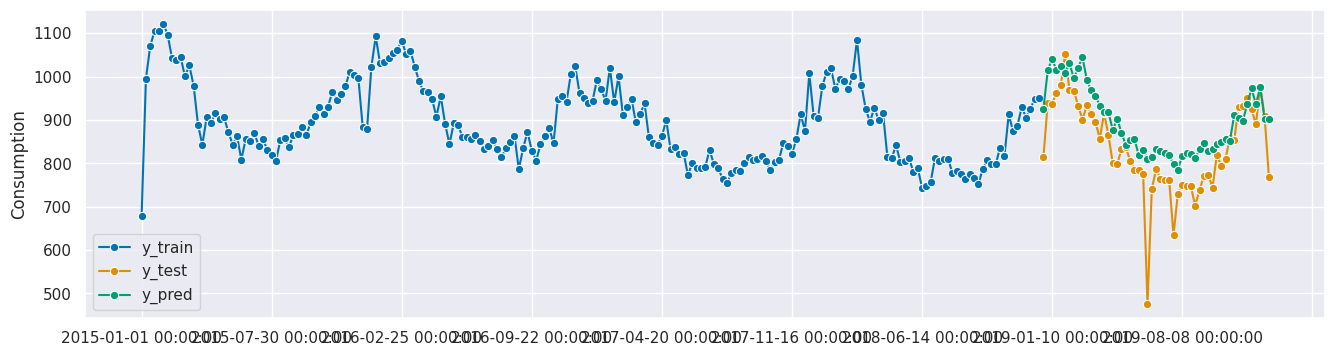

In [ ]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

# объек предсказатель
ses = ExponentialSmoothing()

# пайплайн
forecaster = TransformedTargetForecaster(
                steps=[
                ("deseasonalize", Deseasonalizer(model="multiplicative", sp=SEASON)),
                ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
                ("forecaster", ses)
                ])
forecaster.fit(y_train)

# Предсказание
y_pred = forecaster.predict(fh)

# Результаты
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

## TBATS

sMAPE = 0.053


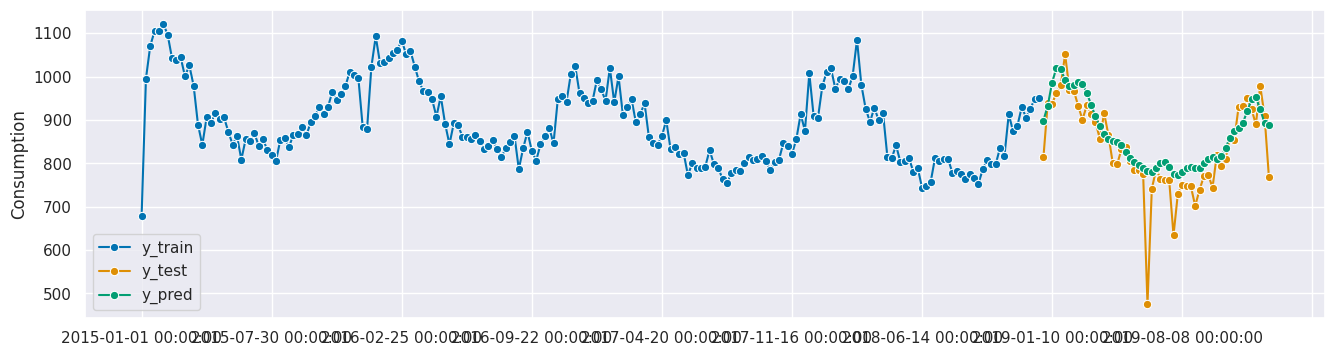

In [ ]:
forecaster = TBATS(
    use_box_cox=True,
    use_trend=True,
    use_damped_trend=True,
    sp=SEASON,
    use_arma_errors=True,
    n_jobs=-1)

forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

## Prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkelnzovi/48n7d6z5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkelnzovi/gz6h7ad8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71008', 'data', 'file=/tmp/tmpkelnzovi/48n7d6z5.json', 'init=/tmp/tmpkelnzovi/gz6h7ad8.json', 'output', 'file=/tmp/tmpkelnzovi/prophet_modelkyn0_47c/prophet_model-20240131154930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:49:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:49:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


sMAPE = 0.048


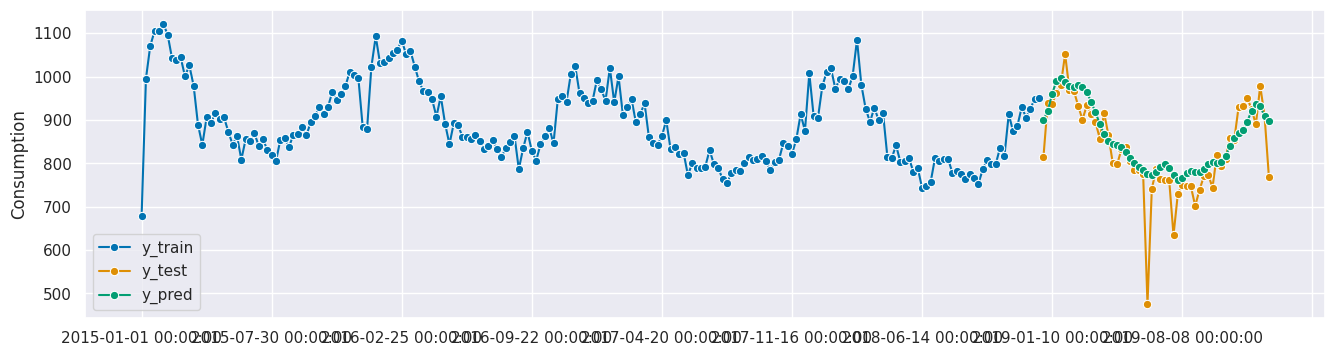

In [ ]:
forecaster = Prophet(freq='1w',
                    seasonality_mode='additive',
#                    seasonality_mode='multiplicative',
                    n_changepoints=int(len(y_train) / 4),
                    add_country_holidays={'country_name': 'GB'},
#                    daily_seasonality=True,
#                    weekly_seasonality=True,
#                    yearly_seasonality=True
                     )

forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

## Вывод по использованным моделям

Из всех моделей лутшие результаты показала модель "Prophet" - 0.48. Больщая часть параметров стоит авто т.к. все очень сомнительно + Добавлены выходные дни по Британии

Но есть преположение, что модель несправляеться с ВР и необходимо использовать, что-то другое например SARIMA или SARIMAX (т.к. в анализе мы выдвигали предположение о том, что на ВР оказывают влияние некие экзоенные факторы)

# SARIMA (метрика sMAPE)

## Общие функции

In [ ]:
P_THRESHOLD = 0.05

In [ ]:
def check_ADF(y, p_threshold=P_THRESHOLD):
    result = adfuller(y)
    adf_value = result[0]
    p_value = result[1]

    print('ADF Statistic: {:.4f}'.format(adf_value))
    print('p-value: {:.4f}'.format(p_value))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.4f}, {}'.format(key, value, 'outperformed' if adf_value > value else ""))
    print(f'Result: The series is {"not " if adf_value > result[4][str(int(p_threshold*100)) + "%"] else ""}stationary')

    return result

def get_plot_RM_RS_deviation(y):
    rolling_mean = y.rolling(window = 12).mean()
    rolling_std  = y.rolling(window = 12).std()

    plt.figure(figsize=(12,4), dpi=100)

    plt.plot(y,      color = 'blue',  label = 'Original')
    plt.plot(rolling_mean, color = 'red',   label = 'Rolling Mean')
    plt.plot(rolling_std,             color = 'black', label = 'Rolling Std')

    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.show()

def get_plot_ACF_PACF(y):
    # Usual Differencing
    plot_acf(y, title='Autocorrelation of Differenced Series', lags=np.arange(80) );plt.show()
    # Usual Differencing
    plot_pacf(y, title='Partial Autocorrelation of Differenced Series', method='ywm', lags=np.arange(60));plt.show()
    plt.show();

def get_plot_model_parram(forecaster, y_train, y_test):
    fhin = ForecastingHorizon(y_train.index[1:], is_relative=False)
    y_in_samples = forecaster.predict(fhin)

    fhout = ForecastingHorizon(y_test.index, is_relative=False)
    y_out = forecaster.predict(fhout)

    plot_series(y_train, y_test, y_in_samples, y_out, labels=["y_train", "y_test", "y_in_samples", "y_out_samples"])

    print(f'sMAPE = {smape(y_out.values, y_test.values):.3f}')

def get_plot_model_dissertation(forecaster, y_train, y_test):
    # Forecast
    forecast_res = forecaster._fitted_forecaster.get_forecast(y_test.size, alpha=0.01, dynamic=False)  # 95% conf

    forecast = forecast_res.predicted_mean

    # Make as pandas series
    fc_series = pd.Series(forecast.values, index=y_test.index)

    lower_series = pd.Series(forecast_res.conf_int()['lower Consumption'], index=y_test.index)
    upper_series = pd.Series(forecast_res.conf_int()['upper Consumption'], index=y_test.index)

    # Plot
    plt.figure(figsize=(16,4), dpi=100)

    plt.plot(y_train, label='training')
    plt.plot(y_test,  label='actual')
    plt.plot(fc_series, label='forecast')

    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                    color='k',
                    alpha=0.15)

    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=12)
    plt.show()

## Без дифференцирования

### Оценка параметров

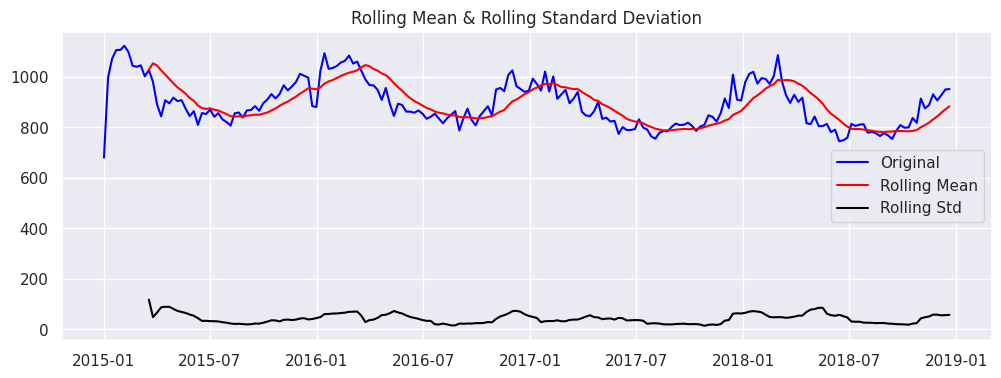

In [ ]:
get_plot_RM_RS_deviation(y_train)

Проведем проверку на стационарность при уровне значимости 0.05

In [ ]:
check_ADF(y_train, p_threshold = P_THRESHOLD);

ADF Statistic: -3.9818
p-value: 0.0015
Critical Values:
	1%: -3.4636, 
	5%: -2.8762, 
	10%: -2.5746, 
Result: The series is stationary


Поскольку p-значение меньше уровня значимости 0,05, мы отвергаем нулевую гипотезу, и ряд считается стационарным вокруг среднего значения.

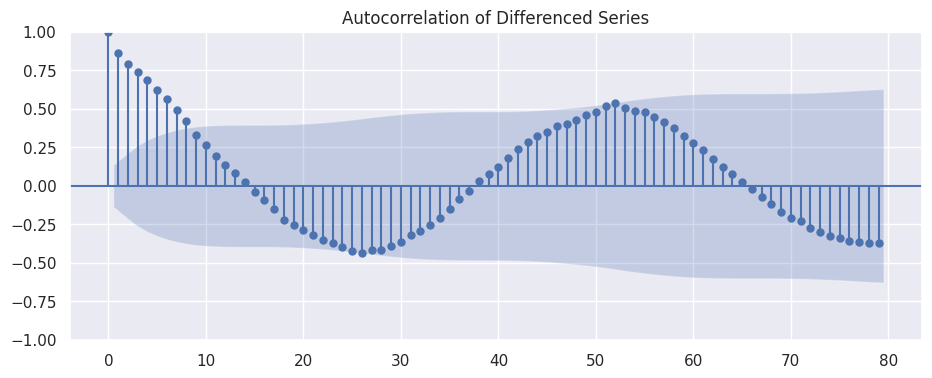

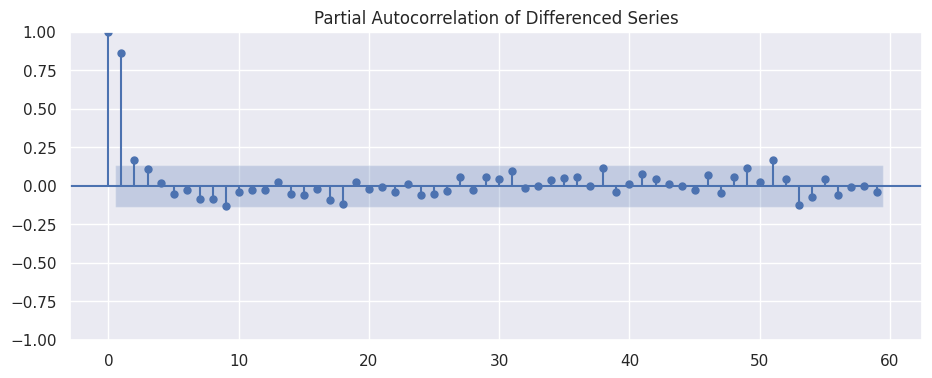

In [ ]:
get_plot_ACF_PACF(y_train)

p = 1 q = 8

### Разложение для оценки Адаптивности и мультипликативности

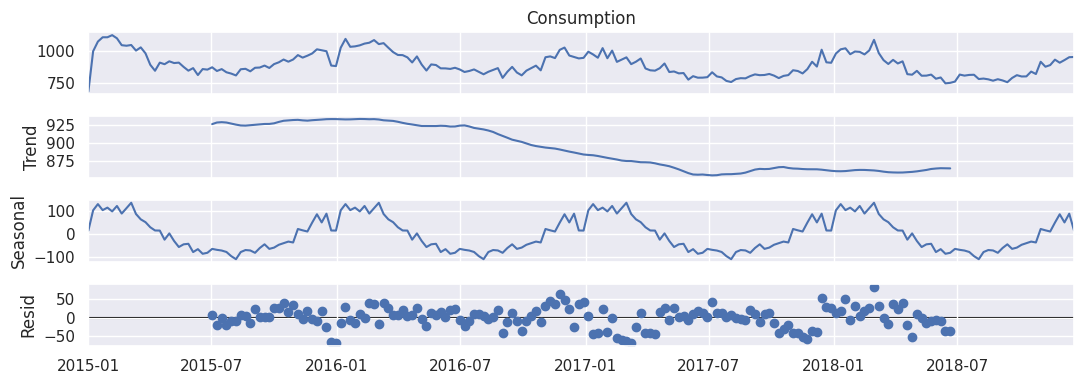

In [ ]:
result = seasonal_decompose(y_train, model='additive', period = SEASON)
result.plot();

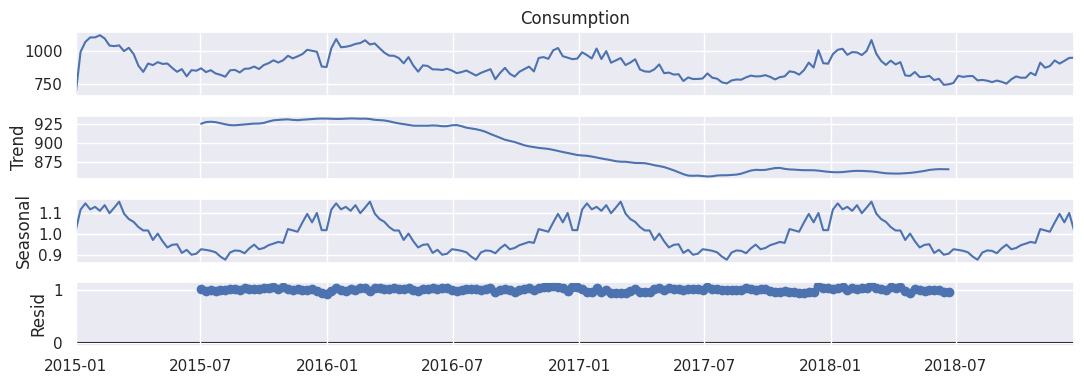

In [ ]:
result = seasonal_decompose(y_train, model='multiplicative', period = SEASON)
result.plot();

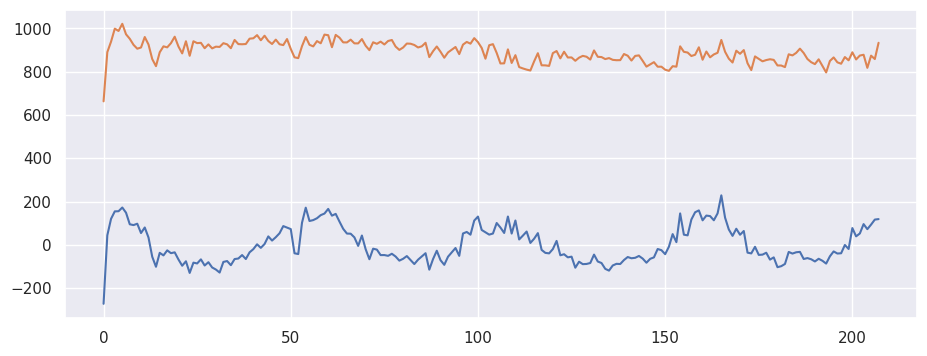

In [ ]:
detrend  = Detrender(forecaster=PolynomialTrendForecaster(degree=1))
plt.plot(detrend.fit_transform(y_train.values))
deseason = Deseasonalizer(model="additive", sp=52)
plt.plot(deseason.fit_transform(y_train.values))

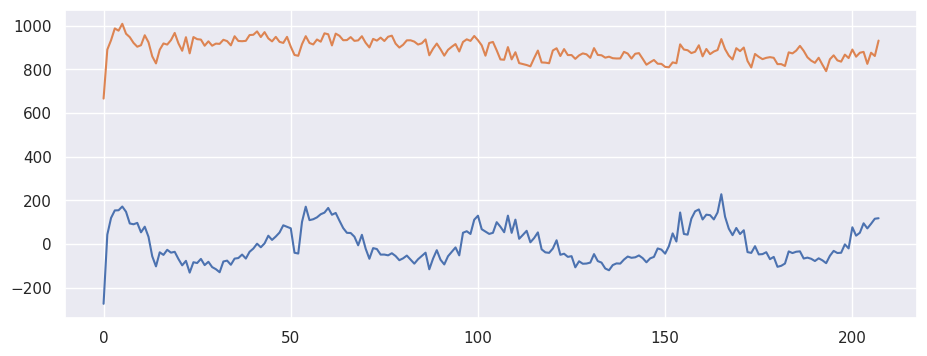

In [ ]:
detrend  = Detrender(forecaster=PolynomialTrendForecaster(degree=1))
plt.plot(detrend.fit_transform(y_train.values))
deseason = Deseasonalizer(model="multiplicative", sp=52)
plt.plot(deseason.fit_transform(y_train.values))

In [ ]:
# Perform ADF test for additive model
adf_result = sm.tsa.stattools.adfuller(y_train)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.9817645914275275
p-value: 0.0015090655773737911
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575


Поскольку p-значение меньше уровня значимости 0,05, мы отвергаем нулевую гипотезу, и ряд считается стационарным вокруг среднего значения.

In [ ]:
# Perform KPSS test for multiplicative model
kpss_result = sm.tsa.stattools.kpss(y_train)
print('KPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])
print('Critical Values:')
for key, value in kpss_result[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.4751912141020997
p-value: 0.04725423105808566
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


Поскольку p-значение больше уровня значимости 0,05, мы не можем отвергнуть нулевую гипотезу, и ряд считается стационарным вокруг детерминированного тренда.

### С предварительными параметрами

In [ ]:
forecaster = SARIMAX(order=(1, 0, 8), seasonal_order=(1, 0, 0, 52))
forecaster.fit(y_train)
print(forecaster.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         Consumption   No. Observations:                  208
Model:             SARIMAX(1, 0, 8)x(1, 0, [], 52)   Log Likelihood               -1065.947
Date:                             Wed, 31 Jan 2024   AIC                           2155.894
Time:                                     15:49:57   BIC                           2195.944
Sample:                                 01-01-2015   HQIC                          2172.088
                                      - 12-20-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    101.8966     51.369      1.984      0.047       1.216     202.578
ar.L1          0.8076      

При уровне значимости 0.05 ПРИСУТСВУЕТ Значимая Гетероскедастичность в остатках, отсутсвует нормальное распределение

sMAPE = 0.079


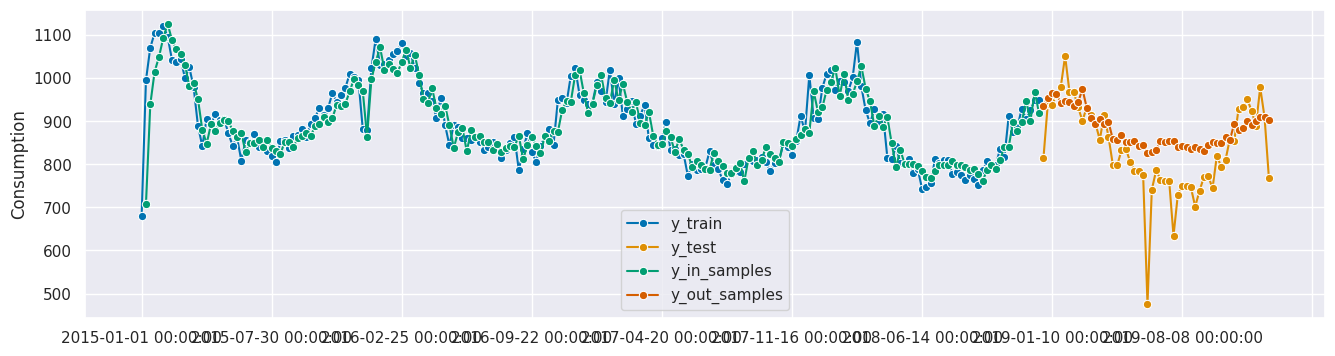

In [ ]:
get_plot_model_parram(forecaster, y_train, y_test)

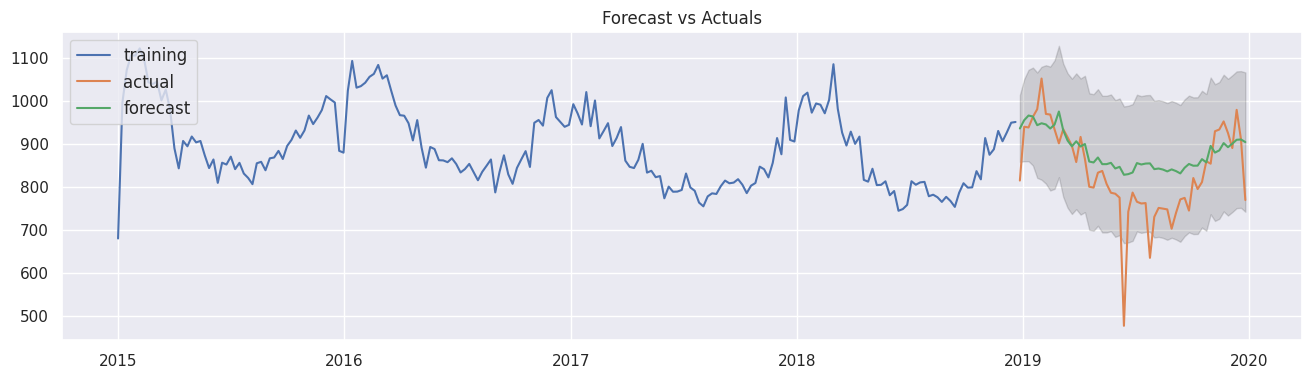

In [ ]:
get_plot_model_dissertation(forecaster, y_train, y_test)

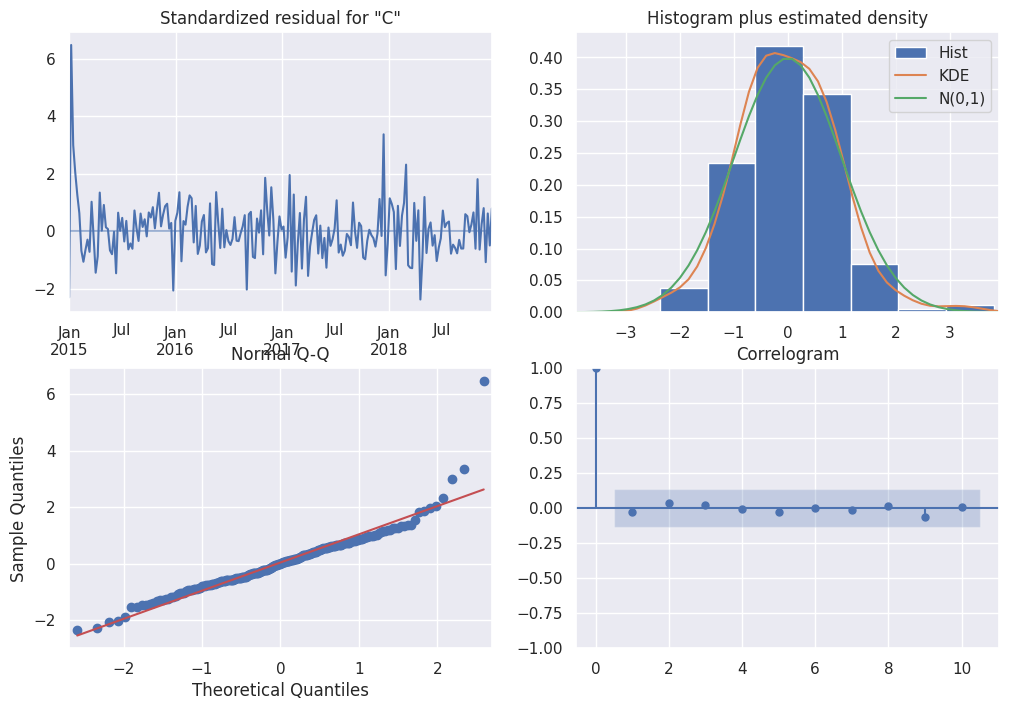

In [ ]:
forecaster._fitted_forecaster.plot_diagnostics(figsize=(12,8));

Выводы по остаткам:

1) Ошибки колеблются около нулевого среднего за исключением какогото всплеска в начале

2) Остатки имеет распределение похожее на нормальное распределение с очень небольшими хвостами

3) Q-Q график показывает отклонения от нормального распределения

4) Автокорреляционная функция не показывает значительных (статистически значимых) отличий от нормального распределения

### Автопоиск оптимальных параметров

In [ ]:
model = AutoARIMA(start_p=1,  # начальный порядок AR
                  d=0,        # Порядок производной
                  start_q=8,  # начальный порядок MA
                  max_p=5,    # конечный порядок AR
                  max_q=8,    # конечный порядок MA
                  seasonal=True,  # Использовать SARIMA
                  start_P=1,  # начальный порядок SAR
                  start_Q=1,  # начальный порядок SMA
                  D=0,        # Порядок сезонной производной
                  sp=52,      # Период сезонности
                  max_order = 17, # Максимальный порядок p+q+P+Q
                  trace  = True,   # отчет он-лайн
                  stepwise = True, # метод ускоренного выбора параметров.
                  n_jobs = 1,      # для stepwise парралелизм не доступен.
                  error_action='ignore',
                  suppress_warnings=True)

model.fit(y_train)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,8)(1,0,1)[52] intercept   : AIC=2150.715, Time=24.54 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2464.206, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2148.562, Time=8.87 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2265.180, Time=3.15 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3420.397, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=2164.506, Time=0.24 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=35.64 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=2152.580, Time=4.30 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=2153.707, Time=2.71 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=2148.920, Time=33.26 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=inf, Time=7.46 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=2148.660, Time=10.07 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=2148.558, Time=5.35 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=2165.794, Time=0.23 sec
 ARIMA(1,0,1)(2,0,0)[52] 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  208
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 52)   Log Likelihood               -1066.229
Date:                            Wed, 31 Jan 2024   AIC                           2144.458
Time:                                    15:56:59   BIC                           2164.483
Sample:                                01-01-2015   HQIC                          2152.555
                                     - 12-20-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     27.2931     22.620      1.207      0.228     -17.042      71.628
ar.L1          0.8788      0.037     23.550      0.000       0.806       0.952
ma.L1         -0.1340      0.054     -2.501      0.012      -0.239      -0.029
ar.S.L52       0.7449      0.200      3.720      0.000       0.352       1.137
ma.S.L52      -0.4474      0.286     -1.563      0.118      -1.009       0.114
sigma2      1571.0482    131.615     11.937      0.000    1313.089    1829.008
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):               612.36
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             1.37
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

sMAPE = 0.078


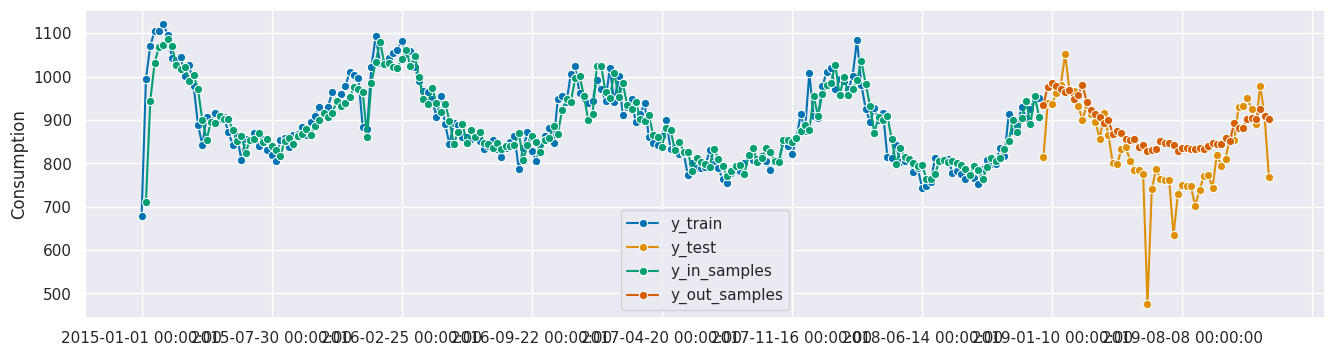

In [ ]:
get_plot_model_parram(model, y_train, y_test)

### Проверим модель с оптимальными параметрами по автопоиску + ручная подгонка

In [ ]:
forecaster = SARIMAX(order=(1, 0, 8), seasonal_order=(1, 0, 1, 52))
forecaster.fit(y_train)
print(forecaster.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                      SARIMAX Results                                       
Dep. Variable:                          Consumption   No. Observations:                  208
Model:             SARIMAX(1, 0, 8)x(1, 0, [1], 52)   Log Likelihood               -1062.357
Date:                              Wed, 31 Jan 2024   AIC                           2150.715
Time:                                      15:57:25   BIC                           2194.103
Sample:                                  01-01-2015   HQIC                          2168.259
                                       - 12-20-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    101.9070    104.168      0.978      0.328    -102.258     306.072
ar.L1          0.40

Значимая Гетероскедастичность в остатках, прямо на границе уровня значимости в 0.5, а так же отсуствие нормального распределния

sMAPE = 0.076


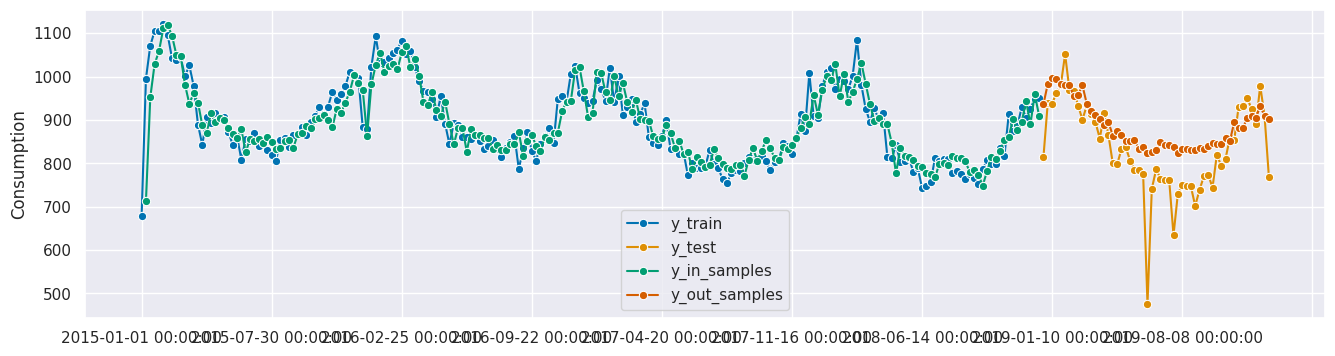

In [ ]:
get_plot_model_parram(forecaster, y_train, y_test)

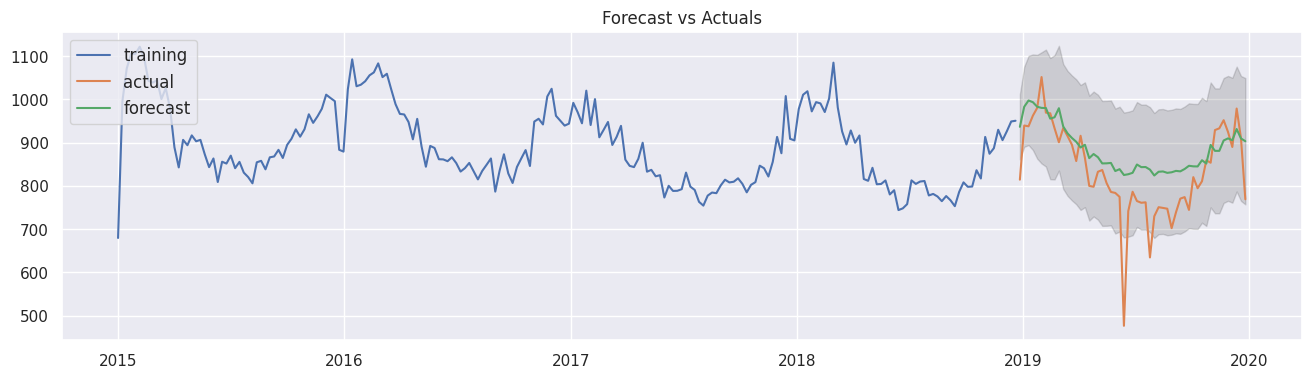

In [ ]:
get_plot_model_dissertation(forecaster, y_train, y_test)

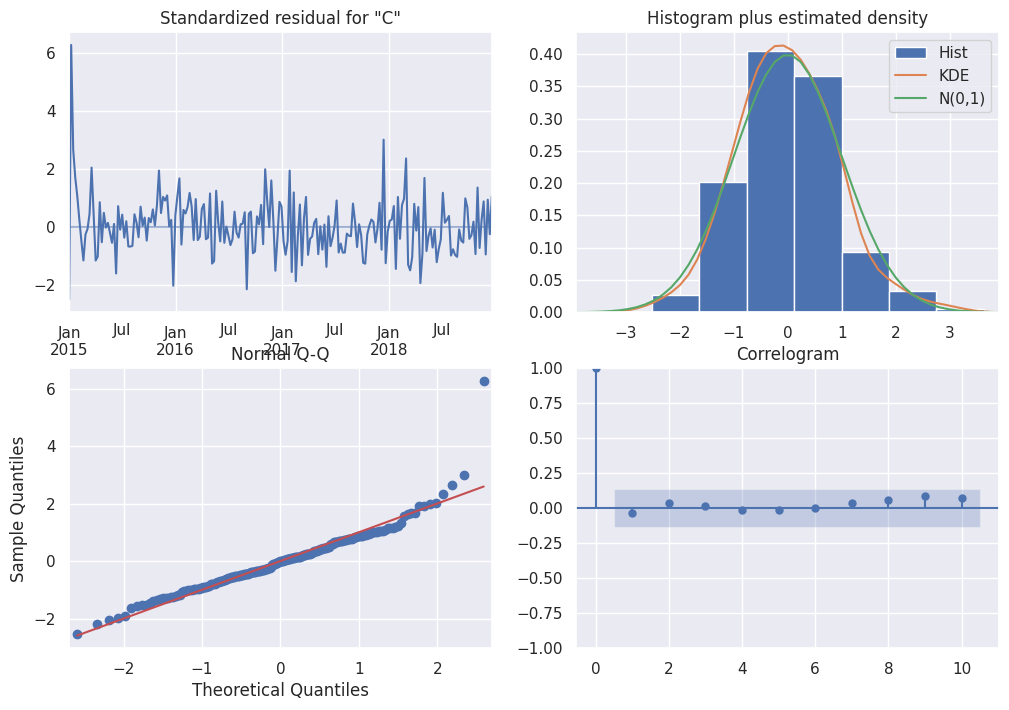

In [ ]:
forecaster._fitted_forecaster.plot_diagnostics(figsize=(12,8));

Выводы по остаткам:

1) Ошибки колеблются около нулевого среднего за исключением какогото выброса в начале

2) Остатки имеет распределение похожее на нормальное распределение с очень небольшими хвостами

3) Q-Q график показывает отклонения от нормального распределения

4) Автокорреляционная функция не показывает значительных (статистически значимых) отличий от нормального распределения

## C дифференцированием

### Оценка параметров

In [ ]:
y_diff = y_train[:].diff(1).dropna()

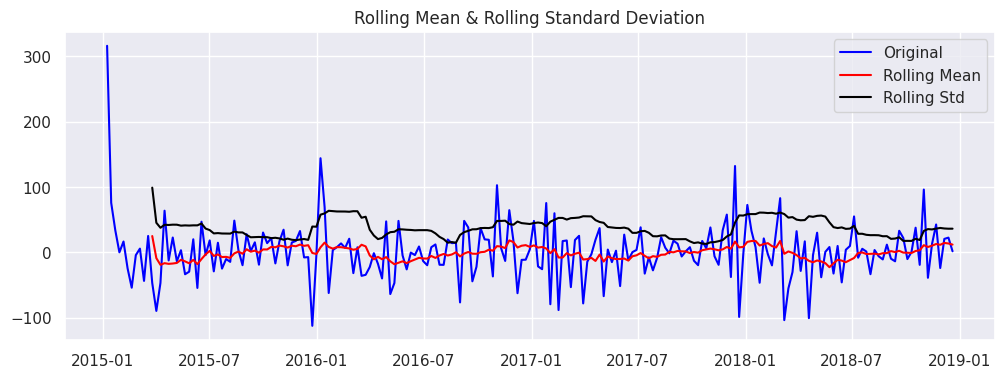

In [ ]:
get_plot_RM_RS_deviation(y_diff)

In [ ]:
check_ADF(y_diff, p_threshold = P_THRESHOLD);

ADF Statistic: -13.4590
p-value: 0.0000
Critical Values:
	1%: -3.4627, 
	5%: -2.8757, 
	10%: -2.5743, 
Result: The series is stationary


Поскольку p-значение меньше уровня значимости 0,05, мы отвергаем нулевую гипотезу, и ряд считается стационарным вокруг среднего значения.

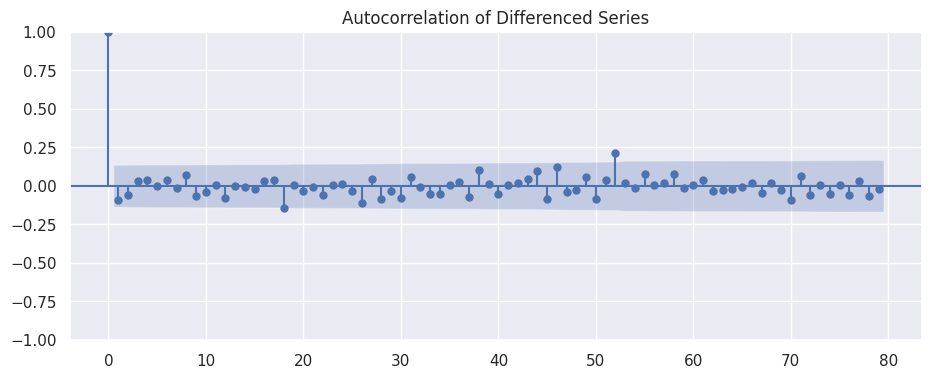

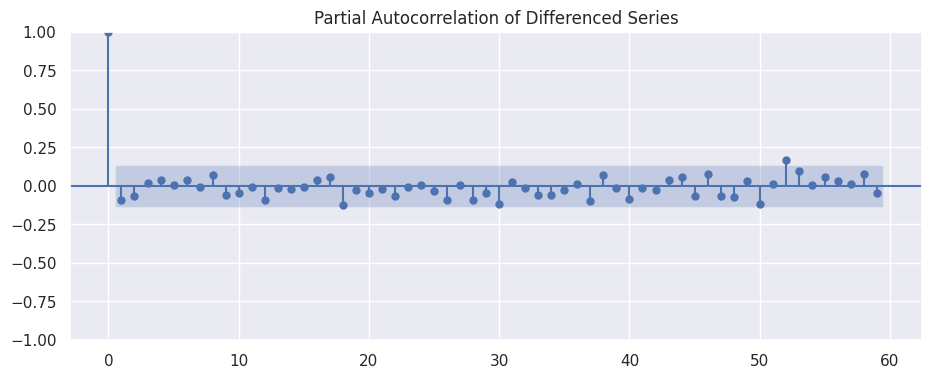

In [ ]:
get_plot_ACF_PACF(y_diff)

После дифференцирования (1) модель похожа на белый шум и кажется ВР гетероскедастичен

Поэтому p и q, 1 и 1, либо 1 и 8, либо 0 и 0 соответственно. Возможно P = 1, Q = 1. Но вот все ОЧЕНЬ САМНИТЕЛЬНО.


### Разложение для оценки Адаптивности и мультипликативности

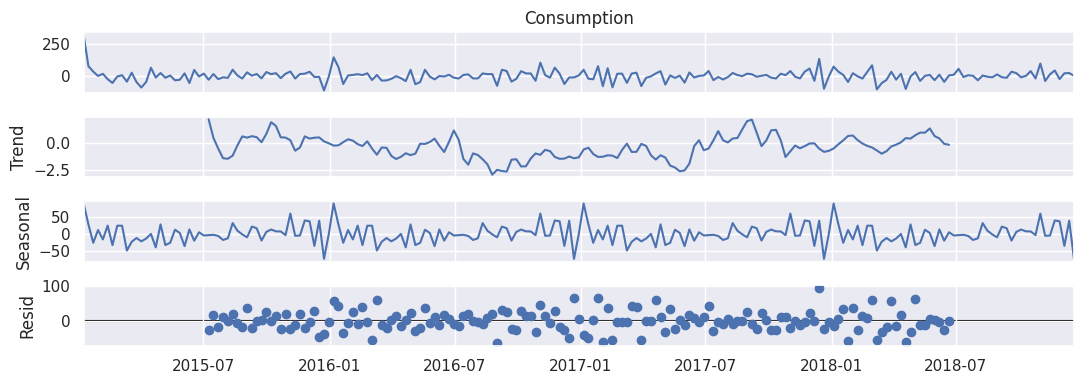

In [ ]:
result = seasonal_decompose(y_diff, model='additive', period = SEASON)
result.plot();

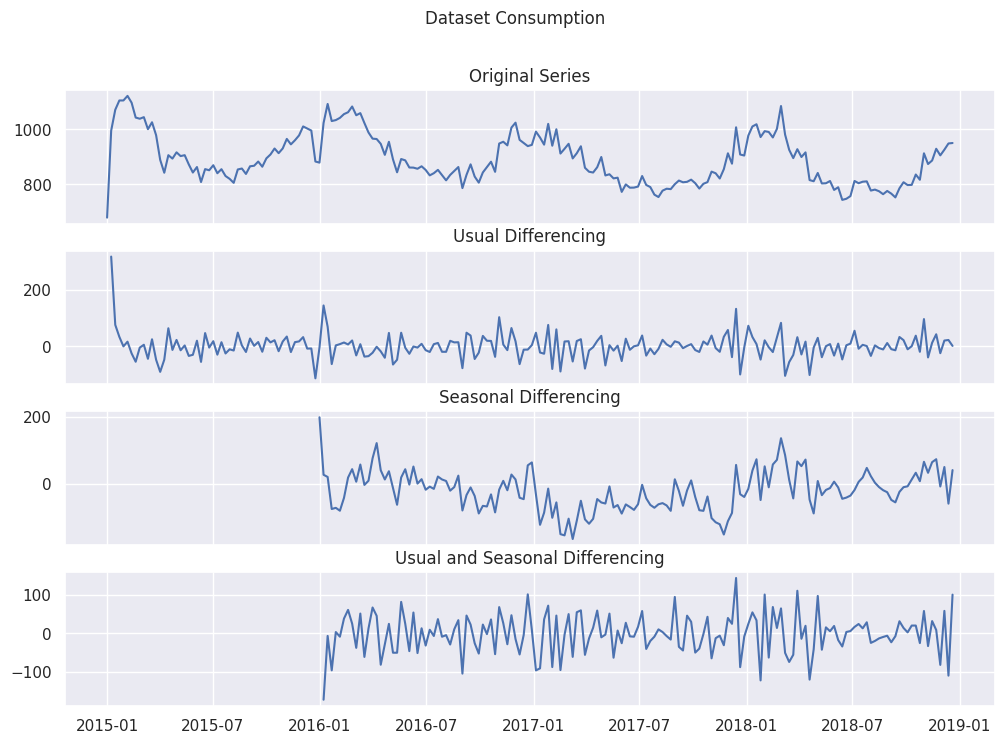

In [ ]:
# Plot
fig, axes = plt.subplots(4, 1, figsize=(12,8), dpi=100, sharex=True)

# Original Series
axes[0].plot(y_train[:])
axes[0].set_title('Original Series')

# Usual Differencing
axes[1].plot(y_train[:].diff(1))
axes[1].set_title('Usual Differencing')

# Seasinal Differencing
axes[2].plot(y_train[:].diff(SEASON))
axes[2].set_title('Seasonal Differencing')

# Seasinal and Usual Differencing
axes[3].plot(y_train[:].diff(1).diff(SEASON))
axes[3].set_title('Usual and Seasonal Differencing')

plt.suptitle('Dataset Consumption', fontsize=12)
plt.show()


Мультипликативная сезонность не подходит для нулевых и отрицательных значений. Поэтому для Дифф = 1, нет мультипликативной модели

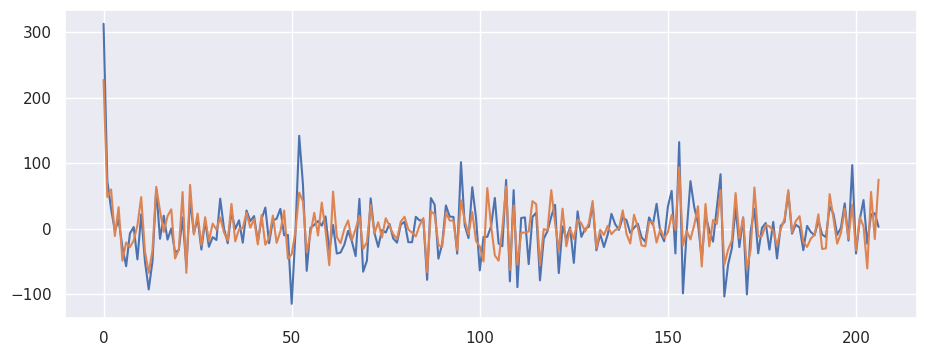

In [ ]:
detrend  = Detrender(forecaster=PolynomialTrendForecaster(degree=1))
plt.plot(detrend.fit_transform(y_diff.values))
deseason = Deseasonalizer(model="additive", sp=52)
plt.plot(deseason.fit_transform(y_diff.values))

Уже неплохо

In [ ]:
# Perform ADF test for additive model
adf_result = sm.tsa.stattools.adfuller(y_diff)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -13.458964808970945
p-value: 3.5609681720804965e-25
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574


Поскольку p-значение меньше уровня значимости 0,05, мы отвергаем нулевую гипотезу, и ряд считается стационарным вокруг среднего значения.

In [ ]:
# Perform KPSS test for multiplicative model
kpss_result = sm.tsa.stattools.kpss(y_diff)
print('KPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])
print('Critical Values:')
for key, value in kpss_result[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.07493965090900884
p-value: 0.1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


<ipython-input-102-c0daf26463db>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = sm.tsa.stattools.kpss(y_diff)


Поскольку p-значение больше уровня значимости 0,05, мы не можем отвергнуть нулевую гипотезу, и ряд считается стационарным вокруг детерминированного тренда.

### Проверим модель с первичными параметрами

In [ ]:
forecaster = SARIMAX(order=(0, 1, 0), seasonal_order=(1, 1, 1, 52))
forecaster.fit(y_train)
print(forecaster.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                      SARIMAX Results                                       
Dep. Variable:                          Consumption   No. Observations:                  208
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 52)   Log Likelihood                -816.755
Date:                              Wed, 31 Jan 2024   AIC                           1641.509
Time:                                      15:57:47   BIC                           1653.683
Sample:                                  01-01-2015   HQIC                          1646.454
                                       - 12-20-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.2890      3.043     -0.424      0.672      -7.253       4.675
ar.S.L52      -0.15

Гетероскедантичность в остатках отсуствует, присутсвует автокореляция в остатках

sMAPE = 0.071


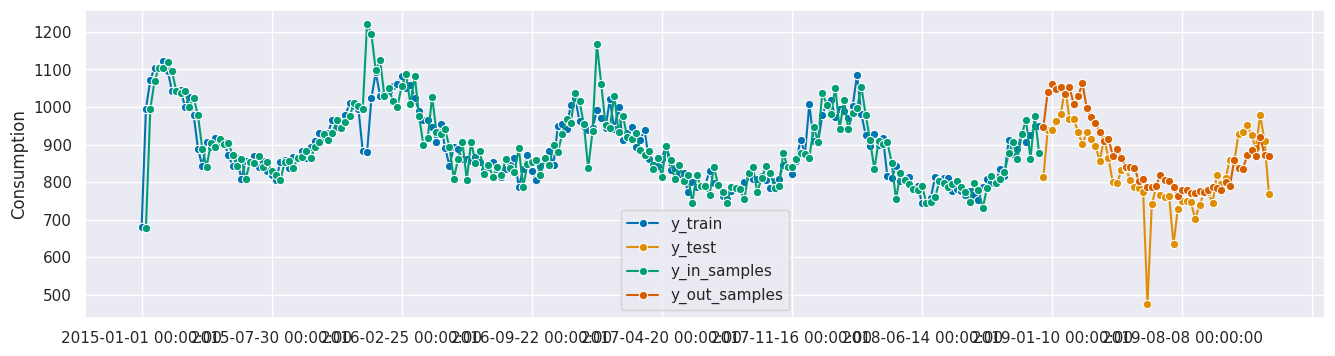

In [ ]:
get_plot_model_parram(forecaster, y_train, y_test)

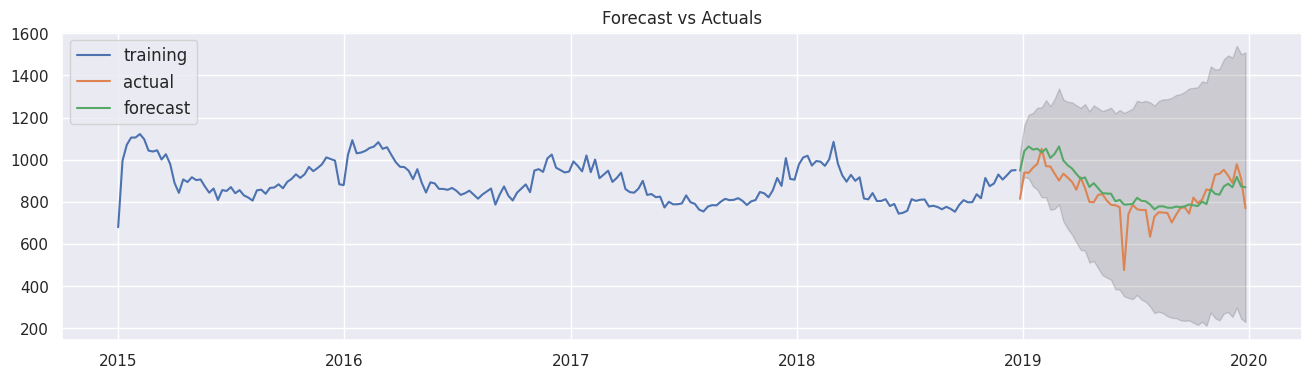

In [ ]:
get_plot_model_dissertation(forecaster, y_train, y_test)

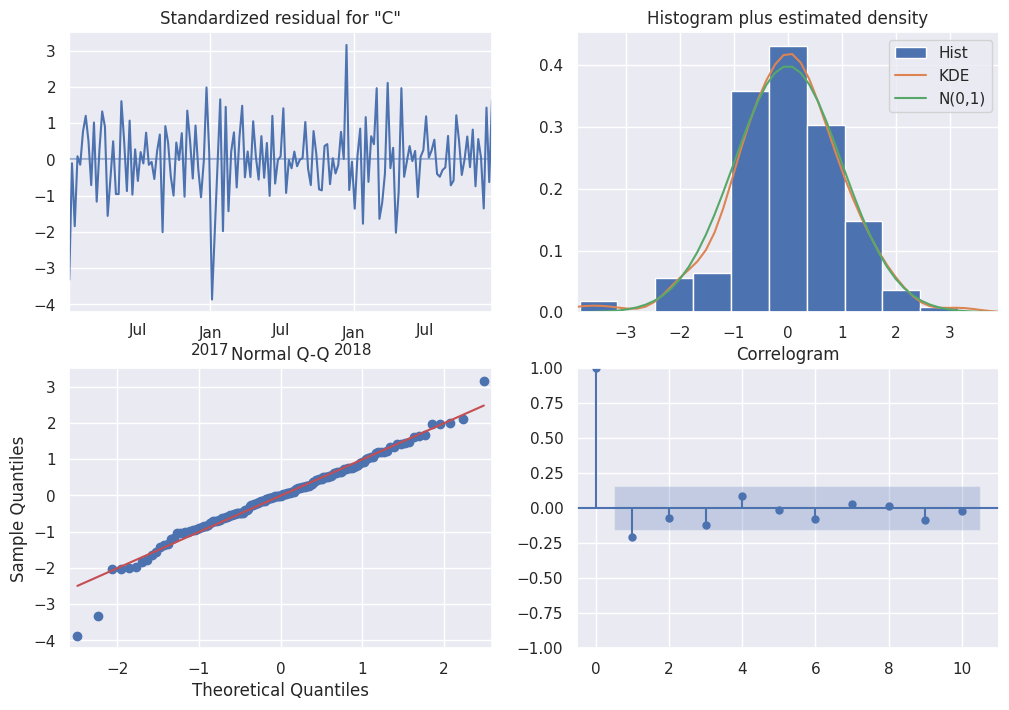

In [ ]:
forecaster._fitted_forecaster.plot_diagnostics(figsize=(12,8));

Выводы по остаткам:

1) Ошибки в основном колеблются около нулевого среднего

2) Остатки имеет распределение похожее на нормальное распределение с небольшими хвостами

3) Q-Q график показывает отклонения от нормального распределения

4) Автокорреляционная функция показывает значительных (статистически значимых) отличий от нормального распределения

### Поиск оптимальных параметров

In [ ]:
model = AutoARIMA(start_p=1,  # начальный порядок AR
                  d=1,        # Порядок производной
                  start_q=1,  # начальный порядок MA
                  max_p=5,    # конечный порядок AR
                  max_q=5,    # конечный порядок MA
                  seasonal=True,  # Использовать SARIMA
                  start_P=1,  # начальный порядок SAR
                  start_Q=1,  # начальный порядок SMA
                  D=1,        # Порядок сезонной производной
                  sp=52,      # Период сезонности
                  max_order = 13, # Максимальный порядок p+q+P+Q
                  trace  = True,   # отчет он-лайн
                  stepwise = True, # метод ускоренного выбора параметров.
                  n_jobs = 1,      # для stepwise парралелизм не доступен.
                  error_action='ignore',
                  suppress_warnings=True)

model.fit(y_train)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[52] intercept   : AIC=1623.771, Time=21.71 sec
 ARIMA(0,1,0)(0,1,0)[52] intercept   : AIC=1665.165, Time=0.74 sec
 ARIMA(1,1,0)(1,1,0)[52] intercept   : AIC=1633.948, Time=8.70 sec
 ARIMA(0,1,1)(0,1,1)[52] intercept   : AIC=1630.041, Time=11.68 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1663.226, Time=0.85 sec
 ARIMA(1,1,1)(0,1,1)[52] intercept   : AIC=1622.459, Time=15.28 sec
 ARIMA(1,1,1)(0,1,0)[52] intercept   : AIC=1640.950, Time=2.89 sec
 ARIMA(1,1,1)(0,1,2)[52] intercept   : AIC=1623.575, Time=46.83 sec
 ARIMA(1,1,1)(1,1,0)[52] intercept   : AIC=1622.495, Time=16.17 sec
 ARIMA(1,1,1)(1,1,2)[52] intercept   : AIC=inf, Time=107.84 sec
 ARIMA(1,1,0)(0,1,1)[52] intercept   : AIC=1633.908, Time=11.65 sec
 ARIMA(2,1,1)(0,1,1)[52] intercept   : AIC=1624.208, Time=16.53 sec
 ARIMA(1,1,2)(0,1,1)[52] intercept   : AIC=1624.231, Time=23.68 sec
 ARIMA(0,1,0)(0,1,1)[52] intercept   : AIC=inf, Time=12.44 sec
 ARIMA(0,1,2)(0,1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  208
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 52)   Log Likelihood                -806.282
Date:                             Wed, 31 Jan 2024   AIC                           1620.564
Time:                                     16:08:31   BIC                           1632.738
Sample:                                 01-01-2015   HQIC                          1625.509
                                      - 12-20-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5283      0.075      7.006      0.000       0.381       0.676
ma.L1         -0.9305      0.044    -21.027      0.000      -1.017      -0.844
ar.S.L52      -0.4302      0.065     -6.623      0.000      -0.557      -0.303
sigma2      1790.6724    164.818     10.865      0.000    1467.635    2113.709
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 9.00
Prob(Q):                              0.81   Prob(JB):                         0.01
Heteroskedasticity (H):               0.68   Skew:                            -0.11
Prob(H) (two-sided):                  0.16   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

sMAPE = 0.050


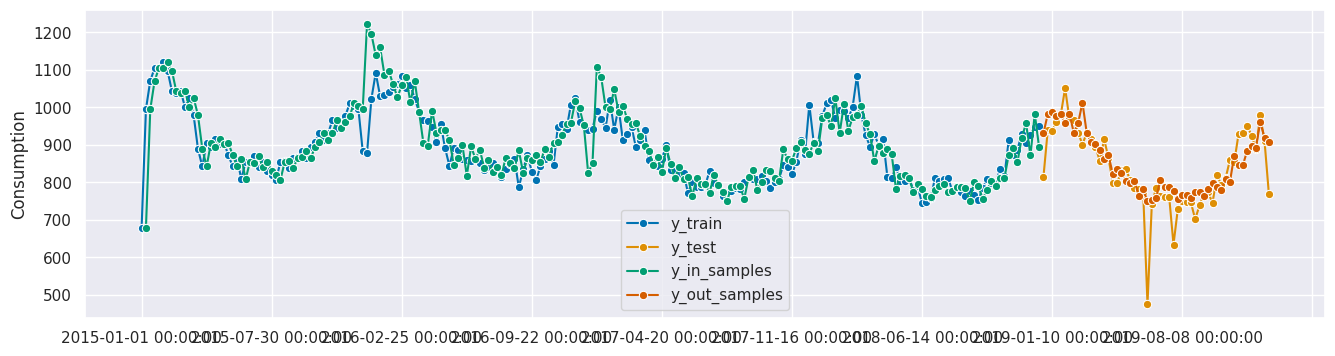

In [ ]:
get_plot_model_parram(model, y_train, y_test)

### Проверим модель с оптимальными параметрами по автопоиску + Ручная подборка

In [ ]:
forecaster = SARIMAX(order=(2, 1, 9), seasonal_order=(2, 1, 0, 52))
forecaster.fit(y_train)
print(forecaster.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         Consumption   No. Observations:                  208
Model:             SARIMAX(2, 1, 9)x(2, 1, [], 52)   Log Likelihood                -802.637
Date:                             Wed, 31 Jan 2024   AIC                           1635.273
Time:                                     16:11:55   BIC                           1680.925
Sample:                                 01-01-2015   HQIC                          1653.816
                                      - 12-20-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.3122      0.947     -0.330      0.742      -2.169       1.544
ar.L1         -0.0290      

На уровне значимости в 0.5 в остатках Гетероскедантичность нет, автокореляции также нет, распределение нормальное

sMAPE = 0.048


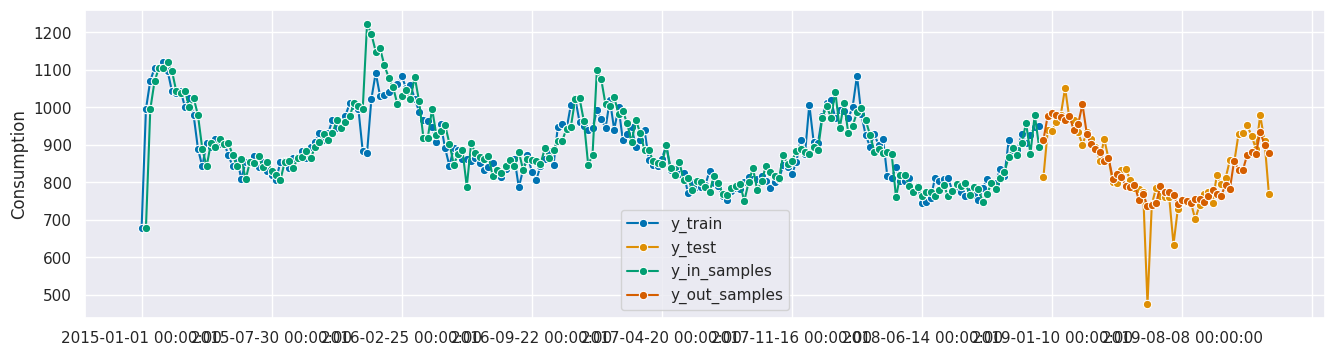

In [ ]:
get_plot_model_parram(forecaster, y_train, y_test)

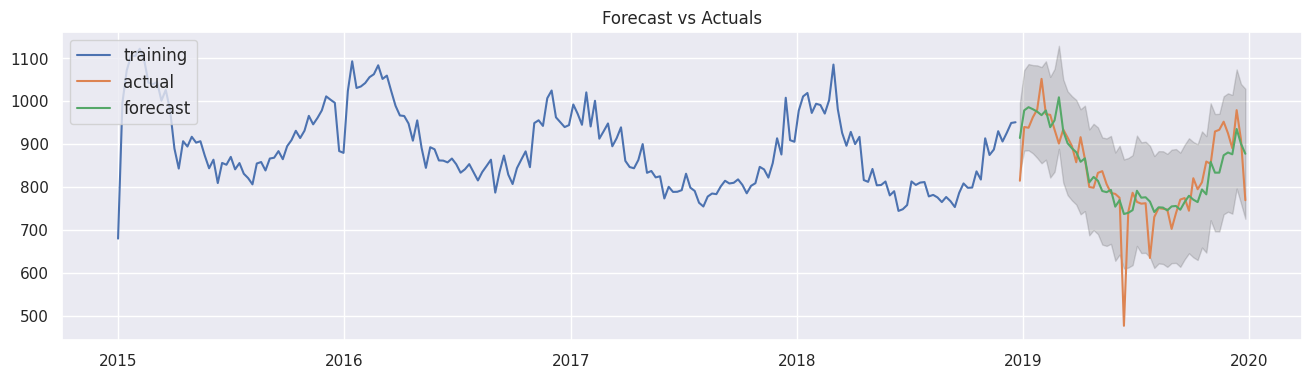

In [ ]:
get_plot_model_dissertation(forecaster, y_train, y_test)

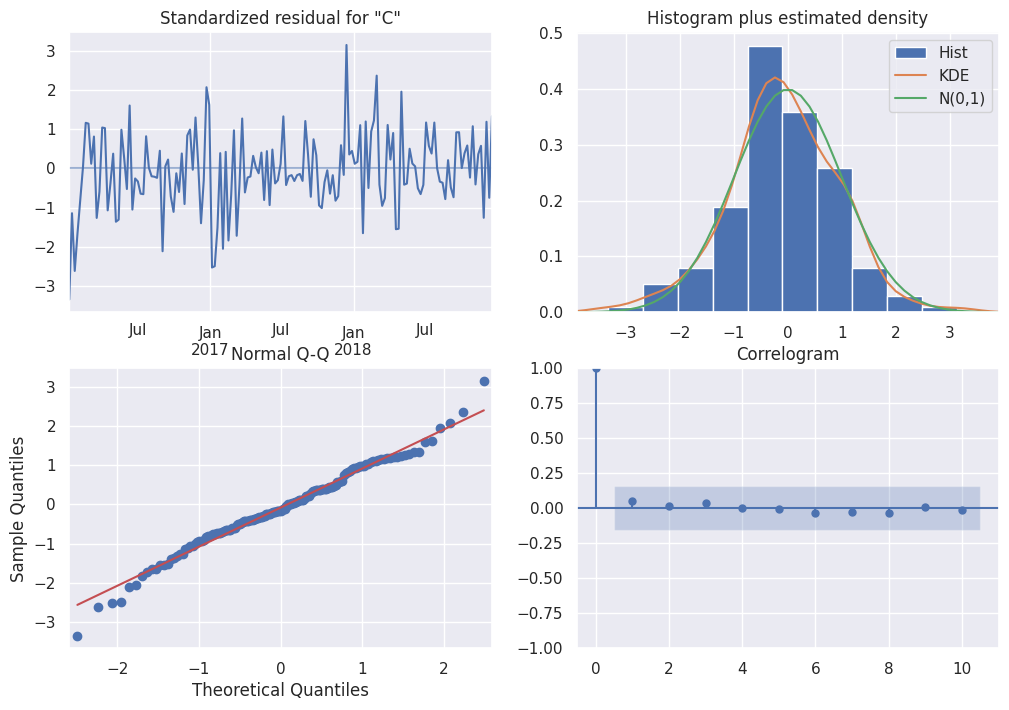

In [ ]:
forecaster._fitted_forecaster.plot_diagnostics(figsize=(12,8));

Выводы по остаткам:

1) Ошибки колеблются около нулевого среднего

2) Остатки имеет распределение похожее на нормальное распределение с небольшими хвостами

3) Q-Q график показывает отклонения от нормального распределения

4) Автокорреляционная функция не показывает значительных (статистически значимых) отличий от нормального распределения

## Выводы по SARIMA

Итоги SARIMA на выборке 0.795/0.205, с сезоном 52, метрикой sMAPE. Значения параметров были взяты посредствам автопоиска + эмпирическим путем для лутшего соотношения sigmi, AIC, точности sMAPE и показателей остатков.

Модель с параметрами (p = 2, d = 1, q = 9, SAR = 2, D = 1, SMA = 0, S = 52) имеет метрику 0.48.

Анализ остатков показал, что при уровне значимости в 0.05 не значимой гетероскедастичнсоти, автокорреляции, а распределение остатков имеет нормальное распределение


Возможно для более точного предсказания можно было бы попробовать ARCH/GARCH (в задание не входит)

## Вывод по предсказаниям на различных моделях и SARIMA

Итоги анализ ВР по энергетике Англии, на выборке 0.795/0.205 с сезоном 52 и метрикой sMAPE.

1) Prophet - 0.48.

2) SARIMA - 0.48 (p = 2, d = 1, q = 9, SAR = 2, D = 1, SMA = 0, S = 52).

3) TBATS - 0.53

Возможно если провести более точную настройку моделей, то метрика покажет более лучший результат.

# Сравнение методов классификации

## Библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
try:
    import sktime
except:
    !pip install sktime --user
    !pip install tsfresh
    !pip install numba
    !pip install llvmlite
import sktime
from sktime.transformations.panel.rocket import MiniRocket
from sktime.datasets import load_from_tsfile
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sktime.datatypes import convert_to

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.shapelet_based import ShapeletTransformClassifier
from sktime.classification.dictionary_based import (ContractableBOSS,
                                                    IndividualBOSS,
                                                    IndividualTDE,
                                                    MUSE, WEASEL)
from sktime.classification.interval_based import (TimeSeriesForestClassifier,
                                                  RandomIntervalSpectralEnsemble,
                                                  SupervisedTimeSeriesForest)
from sklearn.linear_model import RidgeClassifierCV
from sktime.classification.feature_based import SummaryClassifier, Catch22Classifier
from sklearn.ensemble import RandomForestClassifier
from sktime.transformations.panel.summarize import RandomIntervalFeatureExtractor
from sktime.utils.slope_and_trend import _slope
from sklearn.pipeline import Pipeline
from tsfresh import extract_features
from sklearn.preprocessing import MinMaxScaler
from sktime.datatypes._panel._convert import from_nested_to_long

##Общие функции

In [ ]:
def transform_dataframe(df, cols_map):
    # Rename columns for convenience
    df = df[list(cols_map.keys())].rename(columns=cols_map)
    # Convert from MW to GW
    df = df / 1000
    df = df.rename_axis('Date')
    return df

def split_by_month(df, months):
    df_ = pd.DataFrame()
    for month in np.atleast_1d(months):
        df_ = df_.append(df.loc[df.index.month == month])
    return df_

def to_segments(df, column, size = 24):
    df.index.hour[0]
    start_idx = 24-df.index.hour[0]
    df = df.iloc[start_idx:]
    val = df[[column]].values
    return val[:size*(val.size//size)].reshape(-1,size)


In [ ]:
class TopMethod():
    def __init__(self, df = pd.DataFrame(columns=['name_method', 'score'])):
       self.df = df

    def update_total_score(self, name_method, score):
       self.df = self.df.append({'name_method': name_method,
                                 'score': score}, ignore_index=True)

    def get_total_score(self):
        return self.df.sort_values(by='score', ascending=False)

## Завгрузка ряда по потреблению электроэнергии в Англии

In [ ]:
df = transform_dataframe(df_hrly, cols_map).dropna()

# df wind + solar generation
df['Wind+Solar'] = df[['Wind', 'Solar']].sum(axis=1, skipna=False)
df.to_csv('de_clf_data.csv')
df.head()

Consumption   Wind  Solar  Wind+Solar
Date                                                            
2015-01-01 09:00:00+00:00       25.206  0.836  0.013       0.849
2015-01-01 10:00:00+00:00       27.222  0.879  0.063       0.942
2015-01-01 11:00:00+00:00       29.048  0.899  0.054       0.953
2015-01-01 12:00:00+00:00       31.222  0.958  0.046       1.004
2015-01-01 13:00:00+00:00       32.189  0.989  0.037       1.026

In [ ]:
winter = to_segments(split_by_month(df, [1,2, 12]), 'Consumption', size = 24)
summer = to_segments(split_by_month(df, [6, 7, 8]), 'Consumption', size = 24)
autumn = to_segments(split_by_month(df, [9,10,11]), 'Consumption', size = 24)
spring = to_segments(split_by_month(df, [3, 4, 5]), 'Consumption', size = 24)
print(winter.shape, summer.shape, autumn.shape, spring.shape)

(450, 24) (458, 24) (453, 24) (458, 24)


Посмотрим что у нас получилось

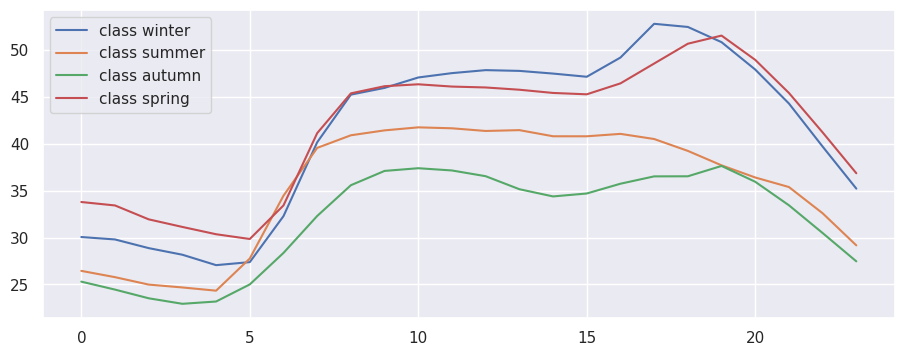

In [ ]:
plt.figure()
day = 10
for i,(c,d) in enumerate(zip([winter,summer,autumn,spring],['winter','summer','autumn','spring'])):
    plt.plot(c[day], label="class " + str(d))
plt.legend(loc="best")
plt.show()
plt.close()

## Разбиение на тренировачную и тестовую выборки

In [ ]:
X = np.concatenate((
                    winter,
                    summer,
                    autumn,
                    spring))
y = np.concatenate((
                    0*np.ones(winter.shape[0]),
                    1*np.ones(summer.shape[0]),
                    2*np.ones(autumn.shape[0]),
                    3*np.ones(spring.shape[0])
                   ))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1273, 24) (1273,) (546, 24) (546,)


Конвертируем в 2d массив

In [ ]:
df_train = convert_to(np.atleast_3d(X_train).transpose(0,2,1), to_type="nested_univ")
df_test  = convert_to(np.atleast_3d(X_test ).transpose(0,2,1), to_type="nested_univ")

Создадим класс для подведения итогов

In [ ]:
tm = TopMethod()

## Методы Классификации

Случайный лес

In [ ]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
tm.update_total_score('RandomForestClassifier', score)
print(f' test score {score:.3f}')

 test score 0.947


k-соседей с евклидовым расстоянием

In [ ]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
tm.update_total_score('KNeighborsClassifier', score)
print(f' test score {score:.3f}')

 test score 0.980


1-NN DTW эластичный метод

In [ ]:
clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="dtw")
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
tm.update_total_score('KNeighborsTimeSeriesClassifier-dtw', score)
print(f' test score {score:.3f}')

 test score 0.943


1-NN DDTW расстояние разностей

In [ ]:
clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="ddtw")
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
tm.update_total_score('KNeighborsTimeSeriesClassifier-ddtw', score)
print(f' test score {score:.3f}')

 test score 0.932


Шейплеты

In [ ]:
clf = ShapeletTransformClassifier(estimator=RandomForestClassifier(n_estimators=100),
                                  n_shapelet_samples=100,
                                  max_shapelets=100,
                                  batch_size=20)

clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
tm.update_total_score('ShapeletTransformClassifier', score)
print(f' test score {score:.3f}')

 test score 0.954


Dictionary

In [ ]:
clf = IndividualBOSS(random_state=47)
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
tm.update_total_score('IndividualBOSS', score)
print(f' test score {score:.3f}')

 test score 0.806


In [ ]:
clf = IndividualTDE(random_state=47)
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
tm.update_total_score('IndividualTDE', score)
print(f' test score {score:.3f}')

 test score 0.881


In [ ]:
clf = MUSE(random_state=47)
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
tm.update_total_score('MUSE', score)
print(f' test score {score:.3f}')

 test score 0.980


На основе признаков

In [ ]:
clf = TimeSeriesForestClassifier(n_estimators=100,random_state=47)
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
tm.update_total_score('TimeSeriesForestClassifier', score)
print(f' test score {score:.3f}')

 test score 0.974


In [ ]:
clf = RandomIntervalSpectralEnsemble(n_estimators=100, random_state=47)
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
tm.update_total_score('RandomIntervalSpectralEnsemble', score)
print(f' test score {score:.3f}')

 test score 0.976


In [ ]:
clf = SupervisedTimeSeriesForest(n_estimators=100, random_state=47)
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
tm.update_total_score('SupervisedTimeSeriesForest', score)
print(f' test score {score:.3f}')

 test score 0.982


Ядерные преобразования

In [ ]:
transform = MiniRocket(num_kernels=10000, n_jobs = -1)
Xt_train = transform.fit_transform(X_train)
Xt_test  = transform.transform(X_test)

clf = RidgeClassifierCV()
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
tm.update_total_score('MiniRocket', score)
print(f' test score {score:.3f}')

 test score 0.874


Признаковые простраства

In [ ]:
clf = SummaryClassifier(estimator=RandomForestClassifier(n_estimators=100))
clf.fit(X_train, y_train)


score = clf.score(X_test, y_test)
tm.update_total_score('SummaryClassifier', score)
print(f' test score {score:.3f}')

 test score 0.639


In [ ]:
clf = Catch22Classifier(estimator=RandomForestClassifier(n_estimators=100))
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
tm.update_total_score('Catch22Classifier', score)
print(f' test score {score:.3f}')

 test score 0.903


Признаковые простраства при помоши библиотеки tsfresh

In [ ]:
Xt_train = extract_features(
            from_nested_to_long(df_train),
            column_id="index",
            column_value="value",
            column_kind="column",
            column_sort="time_index", )
Xt_train.head(2)

Feature Extraction: 100%|██████████| 1273/1273 [01:30<00:00, 14.04it/s]


var_0__variance_larger_than_standard_deviation  var_0__has_duplicate_max  \
0                                             1.0                       0.0   
1                                             1.0                       0.0   

   var_0__has_duplicate_min  var_0__has_duplicate  var_0__sum_values  \
0                       0.0                   0.0            842.939   
1                       0.0                   0.0            837.336   

   var_0__abs_energy  var_0__mean_abs_change  var_0__mean_change  \
0       30929.085619                2.282174           -0.049391   
1       30037.751608                1.430000            0.044261   

   var_0__mean_second_derivative_central  var_0__median  ...  \
0                              -0.142705        39.1080  ...   
1                               0.001000        38.3215  ...   

   var_0__fourier_entropy__bins_5  var_0__fourier_entropy__bins_10  \
0                        0.687092                         0.937156   
1                        0.793730                         0.793730   

   var_0__fourier_entropy__bins_100  \
0                          1.631345   
1                          1.263626   

   var_0__permutation_entropy__dimension_3__tau_1  \
0                                        1.502905   
1                                        1.342927   

   var_0__permutation_entropy__dimension_4__tau_1  \
0                                        2.331253   
1                                        1.722952   

   var_0__permutation_entropy__dimension_5__tau_1  \
0                                        2.692311   
1                                        2.094641   

   var_0__permutation_entropy__dimension_6__tau_1  \
0                                        2.798513   
1                                        2.227525   

   var_0__permutation_entropy__dimension_7__tau_1  \
0                                        2.890372   
1                                        2.293119   

   var_0__query_similarity_count__query_None__threshold_0.0  \
0                                                NaN          
1                                                NaN          

   var_0__mean_n_absolute_max__number_of_maxima_7  
0                                       42.451286  
1                                       39.815143  

[2 rows x 783 columns]

In [ ]:
Xt_test = extract_features(
            from_nested_to_long(df_test),
            column_id="index",
            column_value="value",
            column_kind="column",
            column_sort="time_index", )
Xt_test.head(2)

Feature Extraction: 100%|██████████| 546/546 [00:38<00:00, 14.26it/s]


var_0__variance_larger_than_standard_deviation  var_0__has_duplicate_max  \
0                                             1.0                       0.0   
1                                             1.0                       0.0   

   var_0__has_duplicate_min  var_0__has_duplicate  var_0__sum_values  \
0                       0.0                   0.0            898.695   
1                       0.0                   0.0            713.538   

   var_0__abs_energy  var_0__mean_abs_change  var_0__mean_change  \
0       34528.154015                1.428087           -0.297913   
1       21905.862230                1.448957            0.044696   

   var_0__mean_second_derivative_central  var_0__median  ...  \
0                              -0.071932        40.8675  ...   
1                              -0.044318        32.3800  ...   

   var_0__fourier_entropy__bins_5  var_0__fourier_entropy__bins_10  \
0                        0.535961                         0.937156   
1                        0.793730                         1.043794   

   var_0__fourier_entropy__bins_100  \
0                          1.285293   
1                          1.043794   

   var_0__permutation_entropy__dimension_3__tau_1  \
0                                        1.256130   
1                                        1.162226   

   var_0__permutation_entropy__dimension_4__tau_1  \
0                                        1.897368   
1                                        1.608395   

   var_0__permutation_entropy__dimension_5__tau_1  \
0                                        2.319575   
1                                        2.055845   

   var_0__permutation_entropy__dimension_6__tau_1  \
0                                        2.447940   
1                                        2.360736   

   var_0__permutation_entropy__dimension_7__tau_1  \
0                                        2.582306   
1                                        2.630253   

   var_0__query_similarity_count__query_None__threshold_0.0  \
0                                                NaN          
1                                                NaN          

   var_0__mean_n_absolute_max__number_of_maxima_7  
0                                       42.881429  
1                                       35.357714  

[2 rows x 783 columns]

In [ ]:
Xt_train = (Xt_train - Xt_train.min())/(Xt_train.max() - Xt_train.min()).astype(np.float32)
Xt_test  = (Xt_test  - Xt_train.min())/(Xt_train.max() - Xt_train.min()).astype(np.float32)
Xt_train = Xt_train.dropna(axis=1)
Xt_test  = Xt_test[Xt_train.columns]
clf = RandomForestClassifier(n_estimators=100)
clf.fit(Xt_train, y_train)

score = clf.score(Xt_test, y_test)
tm.update_total_score('RandomForestClassifier-extract_features', score)
print(f' test score {score:.3f}')

 test score 0.513


Пайплайны

In [ ]:
steps = [(
        "extract",  RandomIntervalFeatureExtractor(
            n_intervals="sqrt", features=[np.mean, np.std, _slope]
        )),
    ("clf", RandomForestClassifier()),]

clf = Pipeline(steps)
clf.fit(df_train, y_train)


score = clf.score(df_test, y_test)
tm.update_total_score('Pipeline', score)
print(f' test score {score:.3f}')

 test score 0.929


## Вывод по методам

In [ ]:
tm.get_total_score()

name_method     score
10               SupervisedTimeSeriesForest  0.981685
1                      KNeighborsClassifier  0.979853
7                                      MUSE  0.979853
9            RandomIntervalSpectralEnsemble  0.976190
8                TimeSeriesForestClassifier  0.974359
4               ShapeletTransformClassifier  0.954212
0                    RandomForestClassifier  0.946886
2        KNeighborsTimeSeriesClassifier-dtw  0.943223
3       KNeighborsTimeSeriesClassifier-ddtw  0.932234
15                                 Pipeline  0.928571
13                        Catch22Classifier  0.902930
6                             IndividualTDE  0.880952
11                               MiniRocket  0.873626
5                            IndividualBOSS  0.805861
12                        SummaryClassifier  0.639194
14  RandomForestClassifier-extract_features  0.512821

# Сравнение при помощи глубоких нейроных в TSAI

## Библиотеки

In [ ]:
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null


In [ ]:
from tsai.all import *
import warnings

computer_setup()

os              : Linux-6.1.58+-x86_64-with-glibc2.35
python          : 3.10.12
tsai            : 0.3.8
fastai          : 2.7.13
fastcore        : 1.5.29
torch           : 2.1.0+cu121
device          : cpu
cpu cores       : 1
threads per cpu : 2
RAM             : 12.67 GB
GPU memory      : N/A


In [ ]:
import torch
from torch import nn

##Преобразования данных под TSAI

In [ ]:
X = np.atleast_3d(X).transpose(0,2,1)
y.astype(int)


array([0, 0, 0, ..., 3, 3, 3])

In [ ]:
class_map = {
    0:'winter',
    1:'summer',
    2:'autumn',
    3:'spring',
    }
class_map

labeler = ReLabeler(class_map)
y = labeler(y)


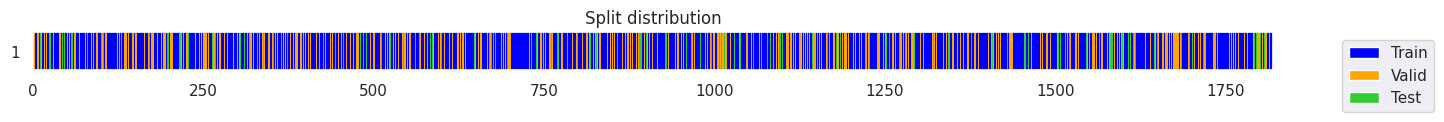

((#1093) [849,1085,1304,540,602,475,28,1276,657,1558...],
 (#545) [478,303,1260,238,1674,89,1222,1193,1190,510...],
 (#181) [692,310,769,647,80,675,453,599,929,1407...])

In [ ]:
splits = get_splits(y,
                    n_splits=1,
                    valid_size=0.3,
                    test_size=0.1,
                    shuffle=True,
                    balance=False,
                    stratify=True,
                    random_state=42,
                    show_plot=True,
                    verbose=True)
splits

In [ ]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)

bs = 256
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])

##Тестирование ячеек

In [ ]:
archs = [
         (RNNPlus, {'n_layers':3, 'bidirectional': True} ),
         (LSTMPlus,{'n_layers':3, 'bidirectional': True} ),
         (GRUPlus, {'n_layers':3, 'bidirectional': True} ),
         (RNNPlus, {'n_layers':4, 'bidirectional': True} ),
         (RNNPlus, {'n_layers':4, 'bidirectional': False}),
         (LSTM,    {'n_layers':3, 'bidirectional': False}),
         (RNN,     {'n_layers':3, 'bidirectional': True} ),
         (LSTM,    {'n_layers':3, 'bidirectional': True} ),
         (GRU,     {'n_layers':3, 'bidirectional': True} ),
         (ResNet, {}),
         #(xresnet1d34, {}),
         #(xresnet1d50_deeper, {}),
         (InceptionTime, {}),
         (XceptionTime,  {}),
         (TCN, {}),
         (LSTM_FCN, {}),
         (TST, {}),
         (FCN, {}),
        ]


In [ ]:
from IPython.display import clear_output

results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])

for i, (arch, k) in enumerate(archs):

    model = create_model(arch, dls=dls, **k)

    print(model.__class__.__name__)

    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(20, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    clear_output()
    display(results)

arch                              hyperparams  total params  \
0          ResNet                                       {}        478724   
1   InceptionTime                                       {}        388868   
2    XceptionTime                                       {}        399480   
3             TST                                       {}        411524   
4        LSTM_FCN                                       {}        315380   
5             FCN                                       {}        264580   
6         RNNPlus  {'n_layers': 4, 'bidirectional': False}         71304   
7         RNNPlus   {'n_layers': 4, 'bidirectional': True}        202604   
8             RNN   {'n_layers': 3, 'bidirectional': True}        142204   
9         RNNPlus   {'n_layers': 3, 'bidirectional': True}        142204   
10       LSTMPlus   {'n_layers': 3, 'bidirectional': True}        566404   
11           LSTM   {'n_layers': 3, 'bidirectional': True}        566404   
12           LSTM  {'n_layers': 3, 'bidirectional': False}        203204   
13            GRU   {'n_layers': 3, 'bidirectional': True}        425004   
14        GRUPlus   {'n_layers': 3, 'bidirectional': True}        425004   
15            TCN                                       {}         66754   

    train loss  valid loss  accuracy  time  
0     0.159706    0.078833  0.981651    42  
1     0.204935    0.095818  0.977982    90  
2     0.614739    0.543534  0.932110   188  
3     0.405554    0.258131  0.919266    86  
4     0.517468    0.348029  0.882569    27  
5     0.509117    0.355085  0.878899    23  
6     0.676198    0.456232  0.858716     9  
7     0.605058    0.408654  0.853211    23  
8     0.669006    0.472311  0.844037    17  
9     0.739445    0.527477  0.823853    24  
10    0.765861    0.544552  0.812844    86  
11    0.773964    0.566280  0.805505    60  
12    0.790431    0.561857  0.796330    28  
13    0.862842    0.635243  0.766972    45  
14    0.871489    0.630747  0.761468    48  
15    1.015245    0.899543  0.704587    74

Опробуем ResNet {} т.к. дата сет не очень большой, поэтому скорость 48 и точность в 0.98  будет оптимальна

In [ ]:
arch = ResNet
k = {}
model = create_model(arch, dls=dls, **k)
model = build_ts_model(ResNet, arch_config=k, dls=dls)

SuggestedLRs(valley=0.0002290867705596611)

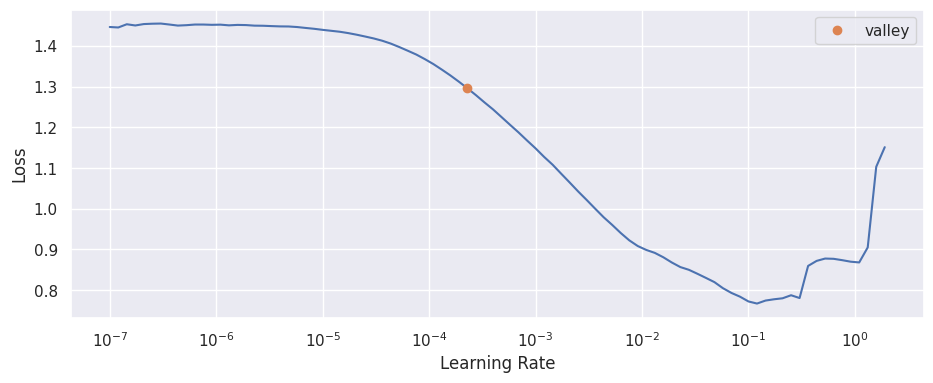

In [ ]:
learn = ts_learner(dls, arch=model, metrics=accuracy)
learn.lr_find()

Т.к. метод достаточно точен, используем 50 эпох

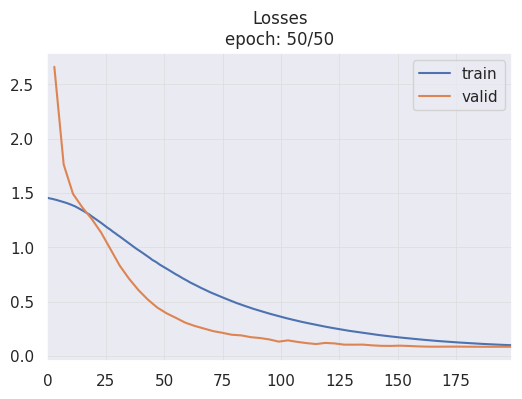

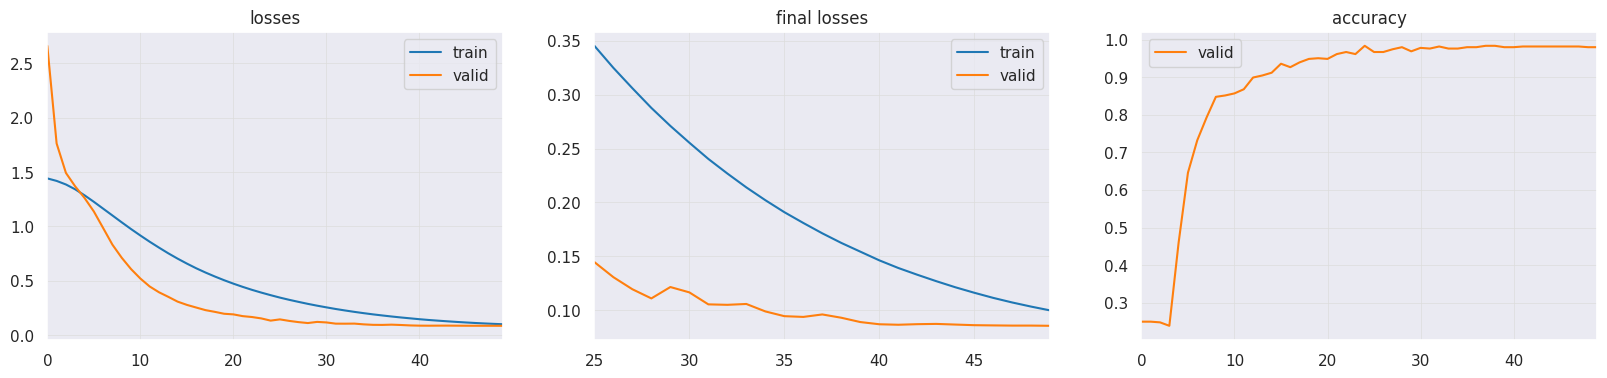

In [ ]:
learn = Learner(dls, model,  metrics=accuracy)
start = time.time()
learn.fit_one_cycle(n_epoch = 50, lr_max = 0.0002, cbs=ShowGraph())

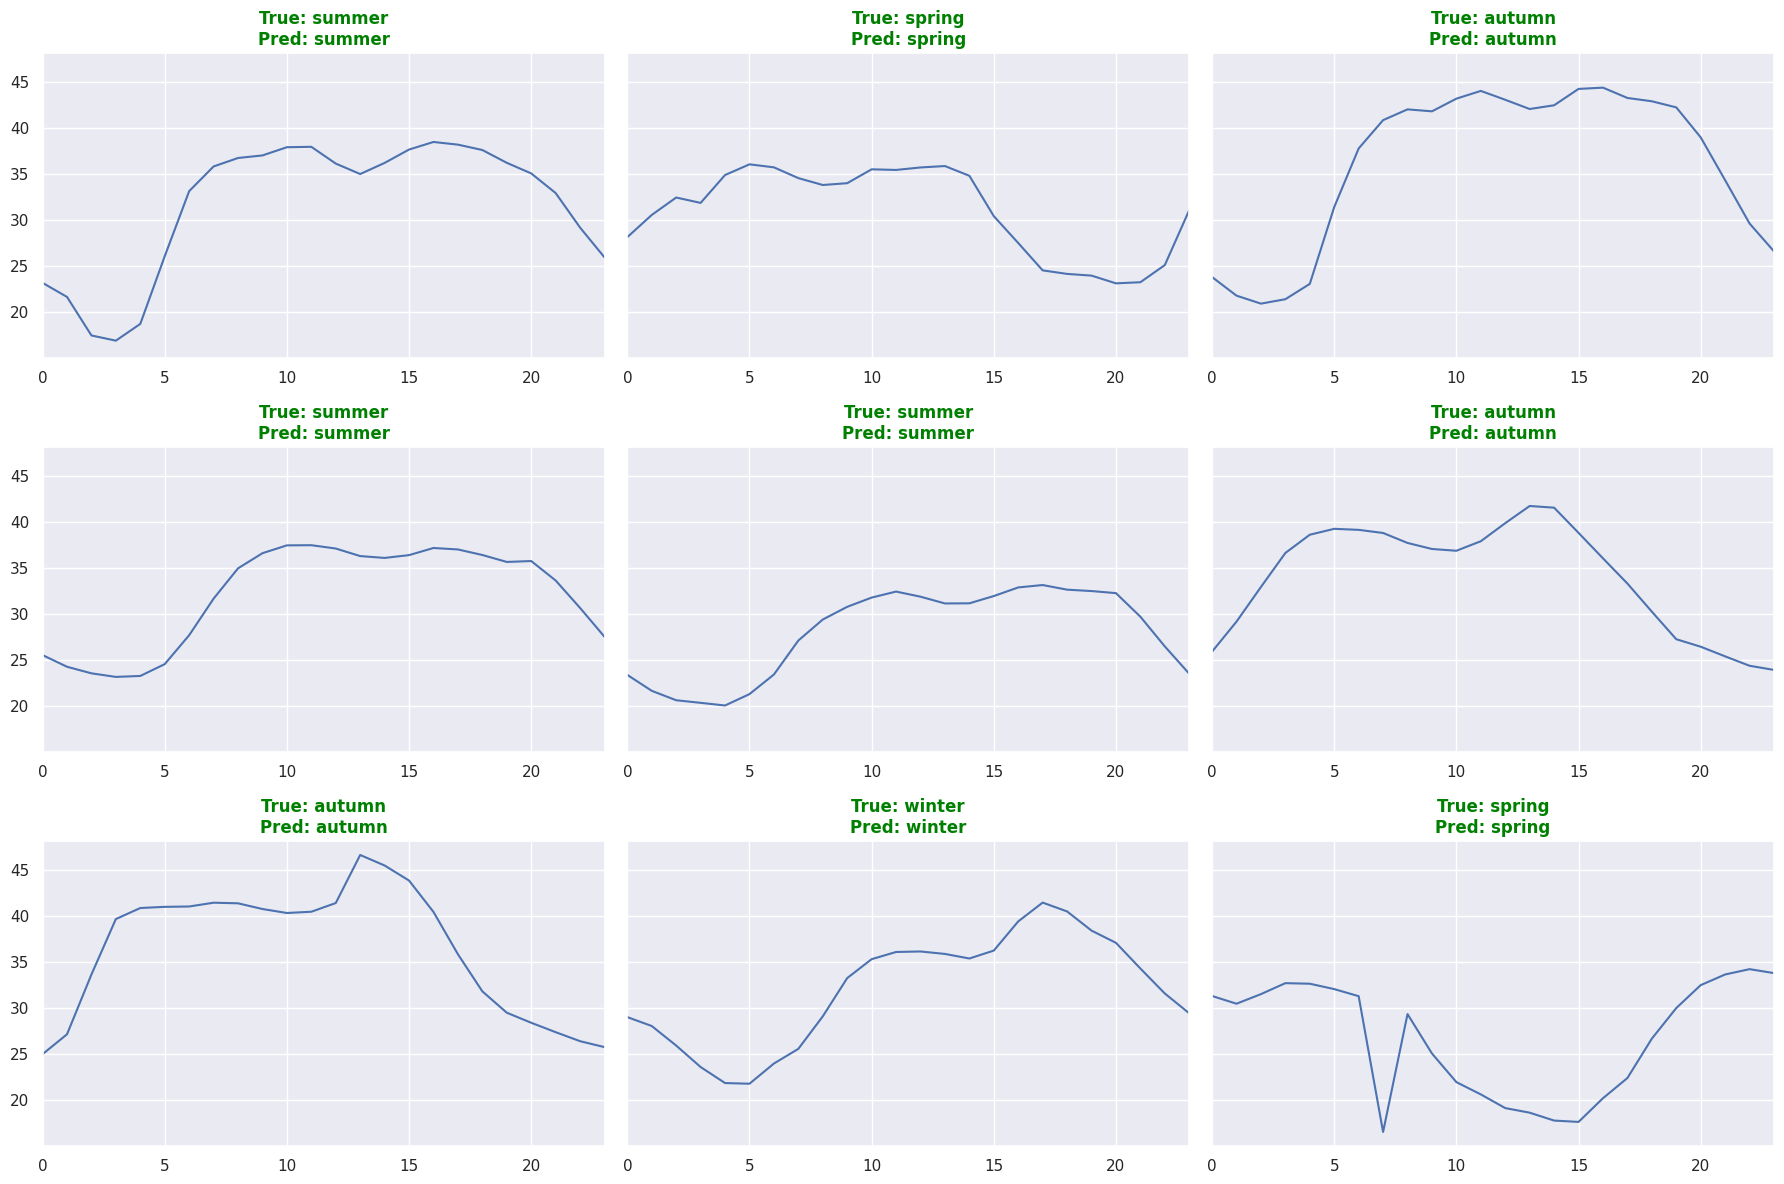

In [ ]:
learn.show_results(sharey=True)

Также для анализа ошибок давайте посмотрим на матрицу ошибок.

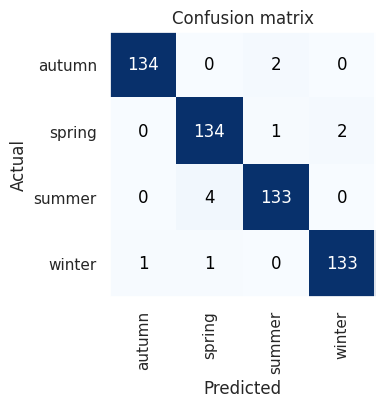

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


Выбирем из матрицы наиболее ошибочные случаи.

In [ ]:
interp.most_confused(min_val=3)

[('summer', 'spring', 4)]

Помимо прочего поппробуем сделать предсказания для тестового набора данных.

In [ ]:
probas, _, preds = learn.get_X_preds(X[splits[2][:5]])
preds, y[splits[2][:5]]


("['summer', 'winter', 'summer', 'summer', 'winter']",
 array(['summer', 'winter', 'summer', 'summer', 'winter'], dtype='<U6'))

Оценим точность на тестовом наборе данных

In [ ]:
probas, _, preds = learn.get_X_preds(X[splits[2]])

In [ ]:
class_map = {
    'winter':3,
    'summer':2,
    'autumn':0,
    'spring':1,
    }


In [ ]:
class_map

{'winter': 3, 'summer': 2, 'autumn': 0, 'spring': 1}

In [ ]:
labeler = ReLabeler(class_map)
from sklearn.metrics import accuracy_score

score = accuracy_score(np.argmax(probas,axis=-1), labeler(y[splits[2]]))
tm.update_total_score('ResNet', score)
print(f' test score {score:.3f}')

 test score 0.989


## Вывод по TSAI и методам

In [ ]:
tm.get_total_score()

name_method     score
16                                   ResNet  0.988950
10               SupervisedTimeSeriesForest  0.981685
7                                      MUSE  0.979853
1                      KNeighborsClassifier  0.979853
9            RandomIntervalSpectralEnsemble  0.976190
8                TimeSeriesForestClassifier  0.974359
4               ShapeletTransformClassifier  0.954212
0                    RandomForestClassifier  0.946886
2        KNeighborsTimeSeriesClassifier-dtw  0.943223
3       KNeighborsTimeSeriesClassifier-ddtw  0.932234
15                                 Pipeline  0.928571
13                        Catch22Classifier  0.902930
6                             IndividualTDE  0.880952
11                               MiniRocket  0.873626
5                            IndividualBOSS  0.805861
12                        SummaryClassifier  0.639194
14  RandomForestClassifier-extract_features  0.512821

Как мы видим Рекурентная нейронная сеть не намного лучше классических методов, но время обучения соотвествеенно больше. Причиной данного результата можно считать относительная простота ряда. Что бы оправдать использование RNN ряд должен быть более сложным и объемным.

# Выявление аномалий

## Библиотеки

In [ ]:
!pip install adtk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.3 MB/s eta 0:00:00


In [ ]:
from adtk.detector import QuantileAD, ThresholdAD, VolatilityShiftAD, LevelShiftAD, SeasonalAD, InterQuartileRangeAD
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN, KMeans
from adtk.visualization import plot

## Завгрузка ряда по потреблению электроэнергии в Англии

In [ ]:
path_ts = 'de_data.csv'
df = pd.read_csv(path_ts, parse_dates=['Date'])

In [ ]:
df=df.fillna(df.mean())

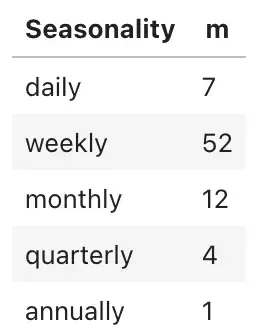

In [ ]:
df = df.set_index(['Date']).asfreq('7d')
df['Traditional'] = df['Consumption'] - df['Solar'] - df['Wind']
df.head()

Consumption        Wind      Solar  Wind+Solar  Traditional
Date                                                                   
2015-01-01      679.307  103.605937  27.108445  130.714382   548.592618
2015-01-08      995.378  136.178000   3.164000  139.342000   856.036000
2015-01-15     1071.180  161.557000   4.044000  165.601000   905.579000
2015-01-22     1104.892   28.053000   3.945000   31.998000  1072.894000
2015-01-29     1104.959  126.444000   4.463000  130.907000   974.052000

## Отобразим ВР

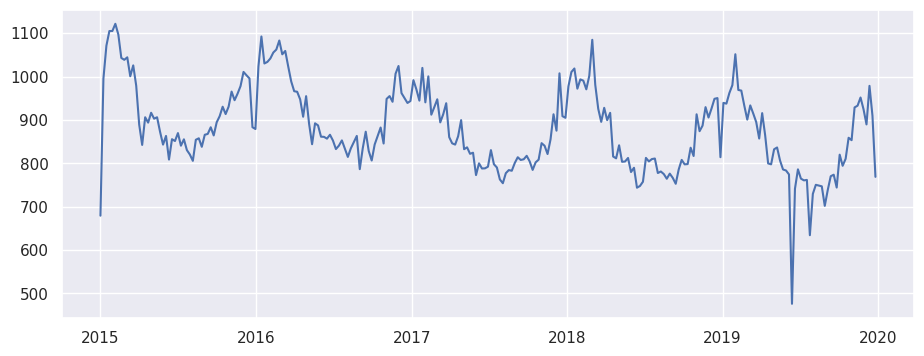

In [ ]:
y = df.Consumption.values.reshape(-1, 1)
plt.plot(df.index, y)

Скользящее средние и скользящие СКО

<Axes: xlabel='Date'>

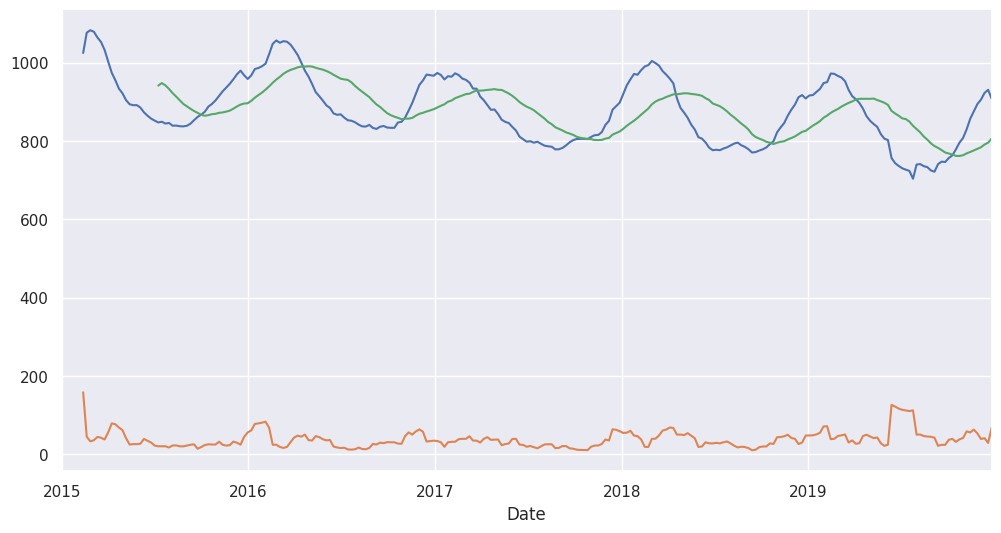

In [ ]:
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)
# create moving-averages
df['Consumption'].rolling(7).mean().plot()
df['Consumption'].rolling(7).std().plot()
df['Consumption'].rolling(7*4).mean().plot()

Дифференцирование

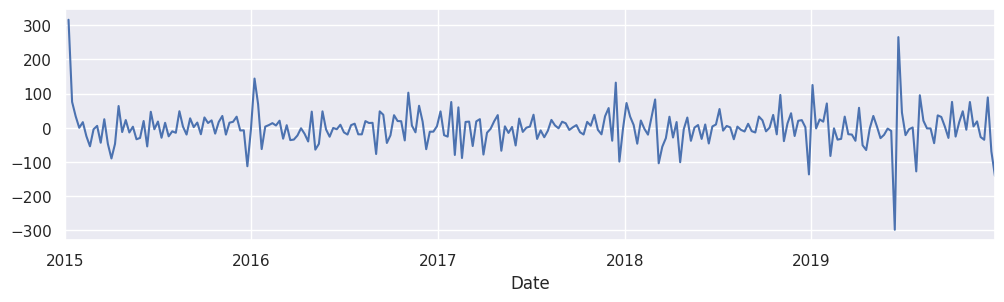

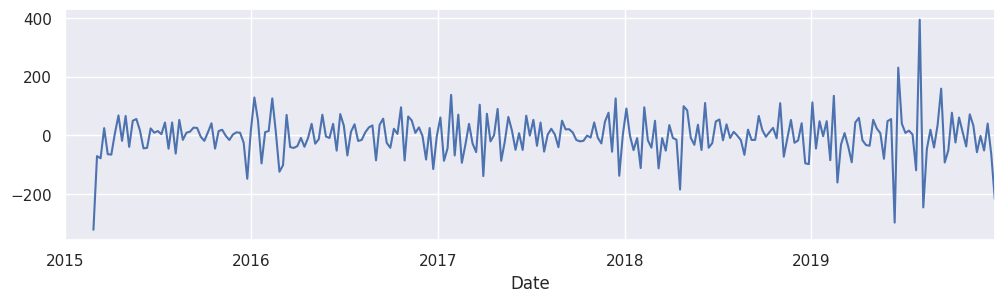

In [ ]:
plt.rc('figure',figsize=(12,3))
plt.rc('font',size=15)

df.Consumption.diff(1).plot(); plt.show()
df.Consumption.diff(7).diff(1).plot(); plt.show()

Простое разложение

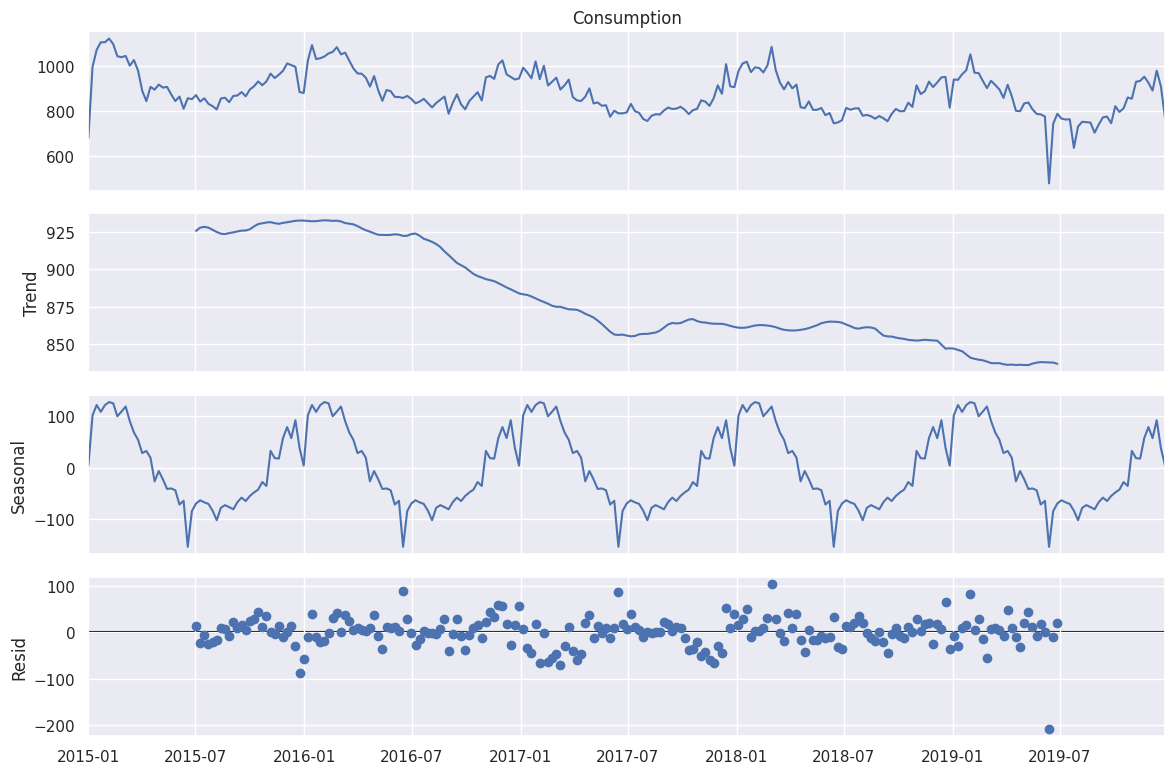

In [ ]:
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=15)

result = seasonal_decompose(df.Consumption,model='additive')
fig = result.plot()

## Выявление

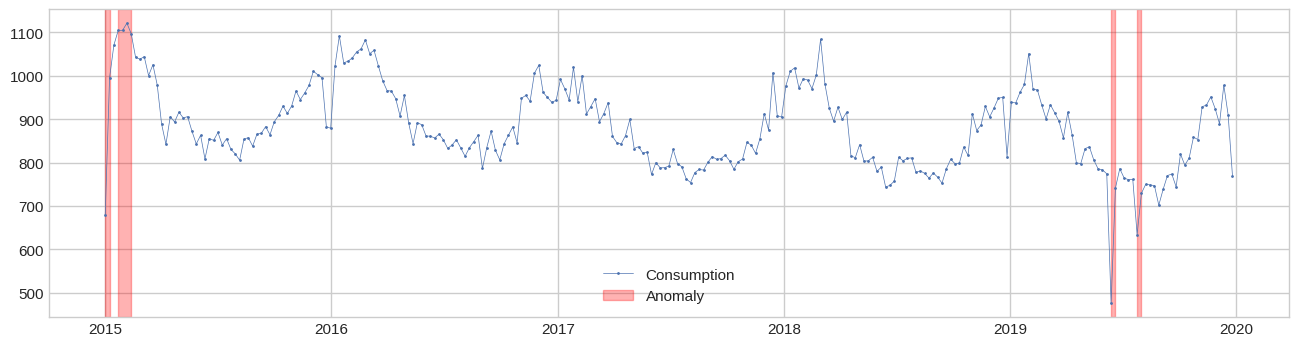

In [ ]:
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(df.Consumption)

plot(df.Consumption, anomaly=anomalies, anomaly_color='red');

На графике общего потребления имееются аномалии в начле года и между 2019-2020 годом. Проведем декомпозицию ряда на традиционные, Солнечные и ветровые источники, что оценить из-за чего эти аномалии

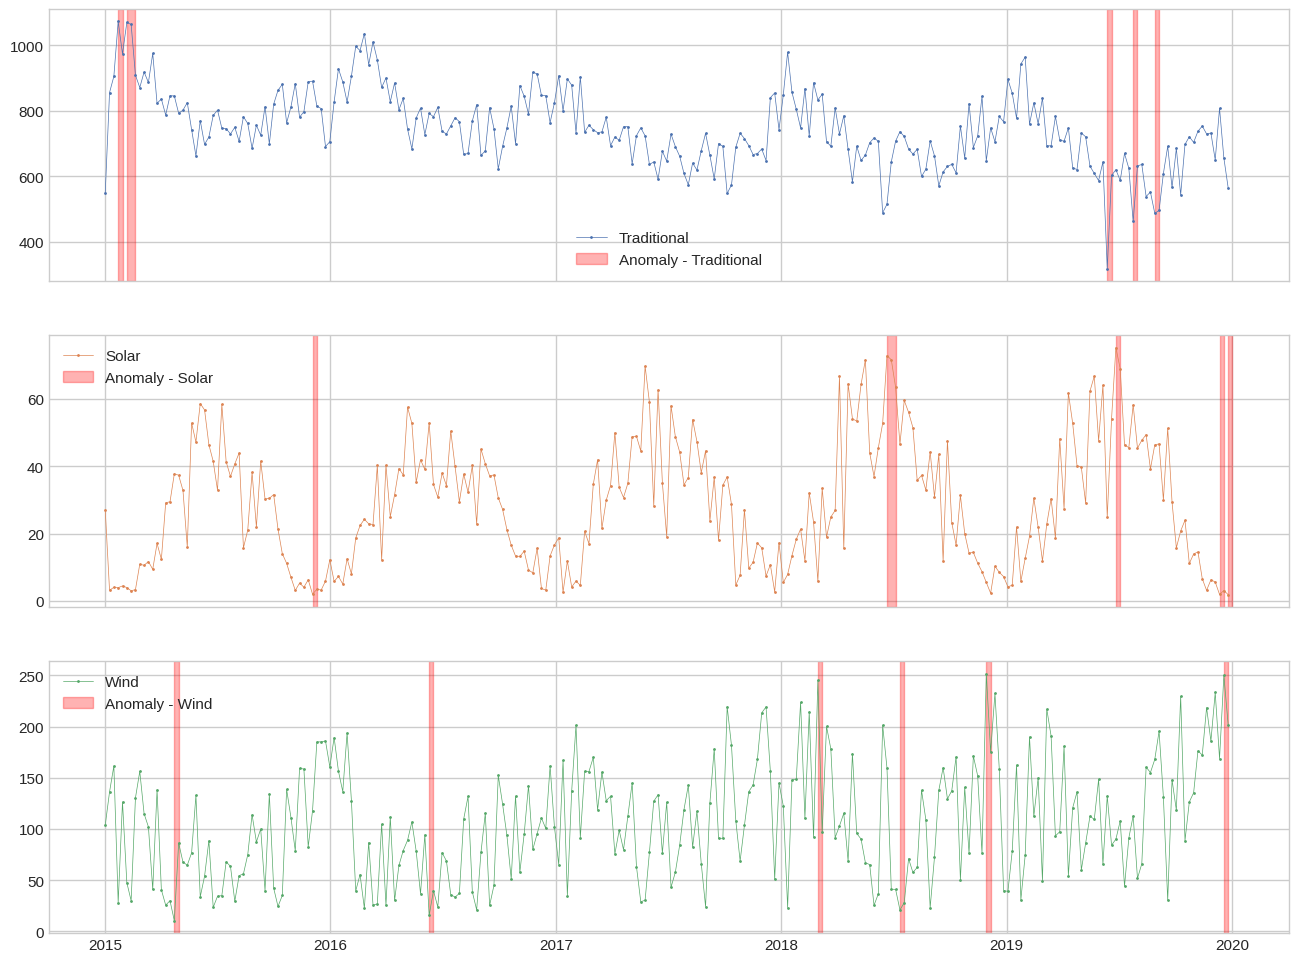

In [ ]:
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(df[['Traditional', 'Solar', 'Wind']])

plot(df[['Traditional', 'Solar', 'Wind']], anomaly=anomalies, anomaly_color='red');

По всей видимости на аномальные значения ряда указывают какие то экзогенные факторы оказывающие влияние на традиционные источники. Допустим если в начале 2015 года люди еще очень АКТИВНО праздниовали новый год, но вот что происходило в традиционной энергетике летом 2019-2020 непонятно

Из [источников](https://eepir.ru/technical_article/sistemnaja-avarija-v-jenergosisteme-vel/) становиться понятно, что в августе 2019 в Англии прозошло маштабное отключение электроэнергии

Стоит заменить, что на признак Общее потребление вполне вероятно содержит в себе не только Ветренные и Солнечные источники, но еще и Биомассы, Уголь, Атом, Газ, Гидро.

Что косамое алтернативных источников то, по всей видимости сказывались сезонные погодные условия

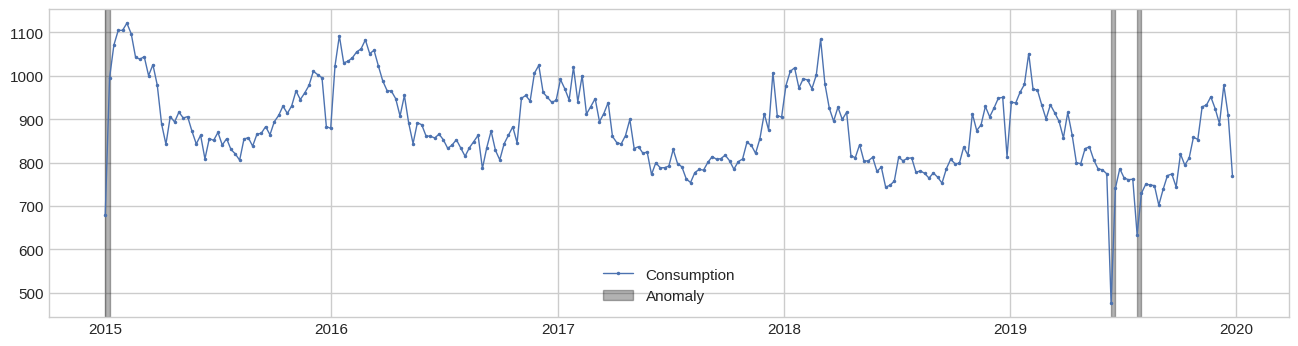

In [ ]:
threshold_val = ThresholdAD(high=1200, low=700)
anomalies_thresh = threshold_val.detect(df.Consumption)
anomalies_thresh.value_counts()

plot(df.Consumption, anomaly=anomalies_thresh, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='black');

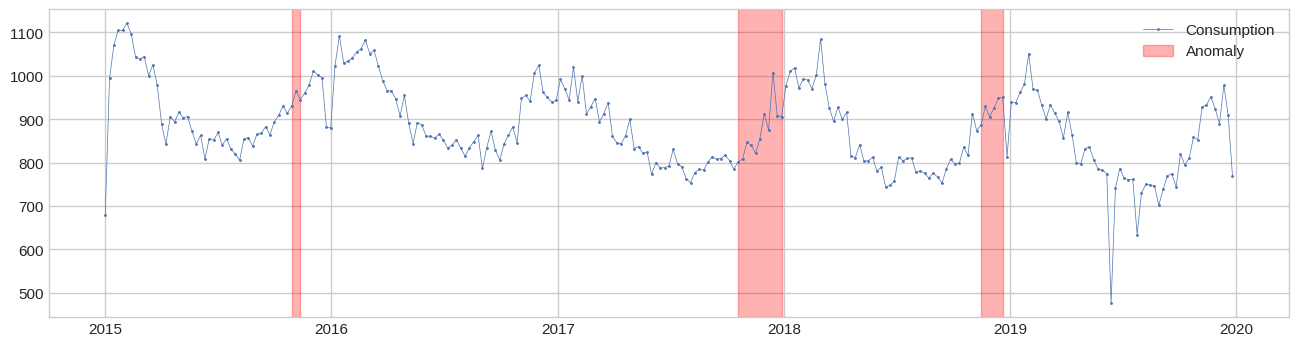

In [ ]:
volatility_shift_ad = VolatilityShiftAD(c=1.0, side='positive', window=30)
anomalies = volatility_shift_ad.fit_detect(df.Consumption)

plot(df.Consumption, anomaly=anomalies, anomaly_color='red');

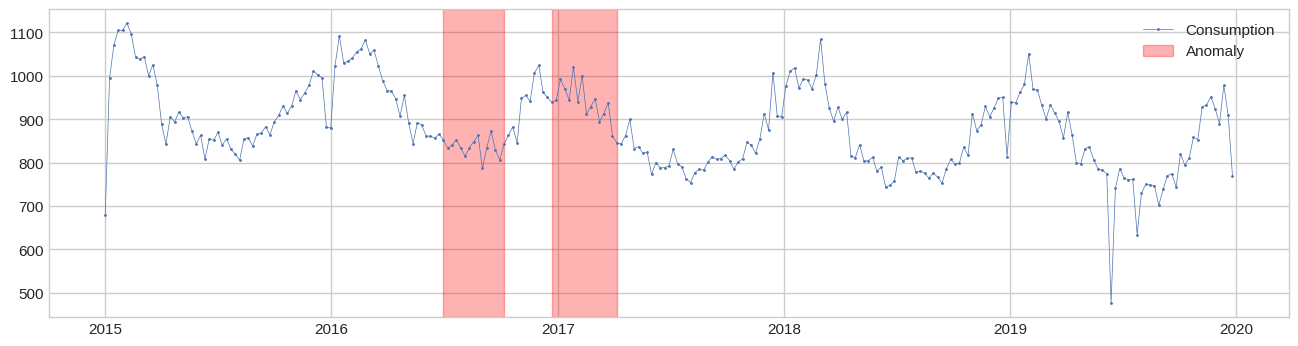

In [ ]:
level_shift_ad = LevelShiftAD(c=0.2, side='both', window=50)
anomalies = level_shift_ad.fit_detect(df.Consumption)

plot(df.Consumption, anomaly=anomalies, anomaly_color='red');

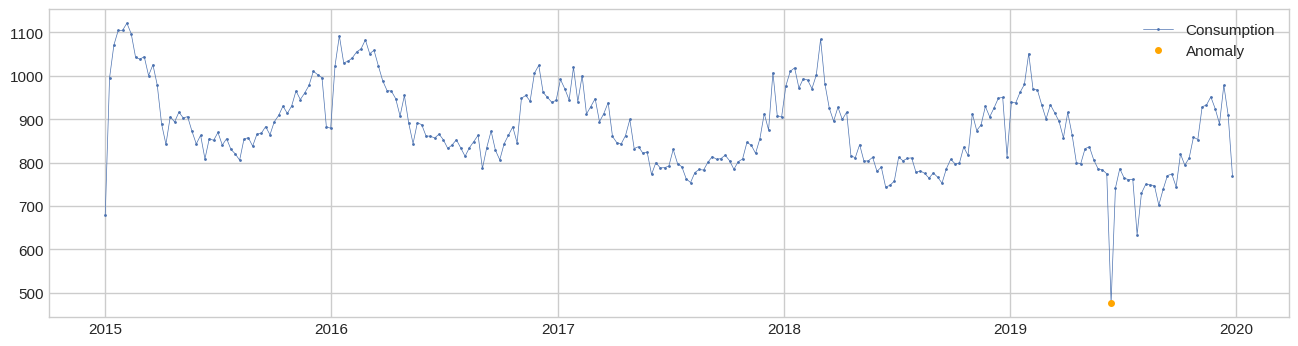

In [ ]:
seasonal_vol = SeasonalAD()
anomalies = seasonal_vol.fit_detect(df.Consumption)
anomalies.value_counts()

plot(df.Consumption, anomaly=anomalies, anomaly_color="orange", anomaly_tag="marker");

Значение выпавшее из сезооности

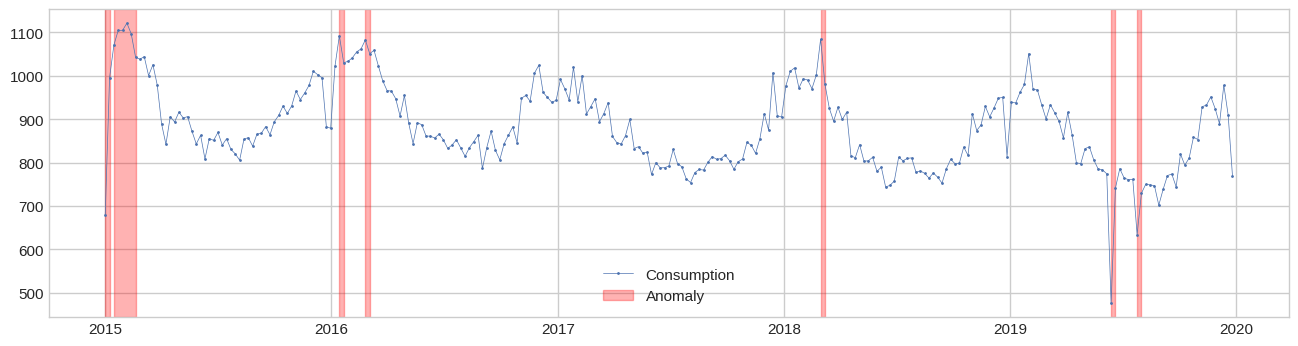

In [ ]:
iqr_ad = InterQuartileRangeAD(c=0.9)
anomalies = iqr_ad.fit_detect(df.Consumption)

plot(df.Consumption, anomaly=anomalies, anomaly_color='red');

Также могут быть использованы специализированные алгоритмы

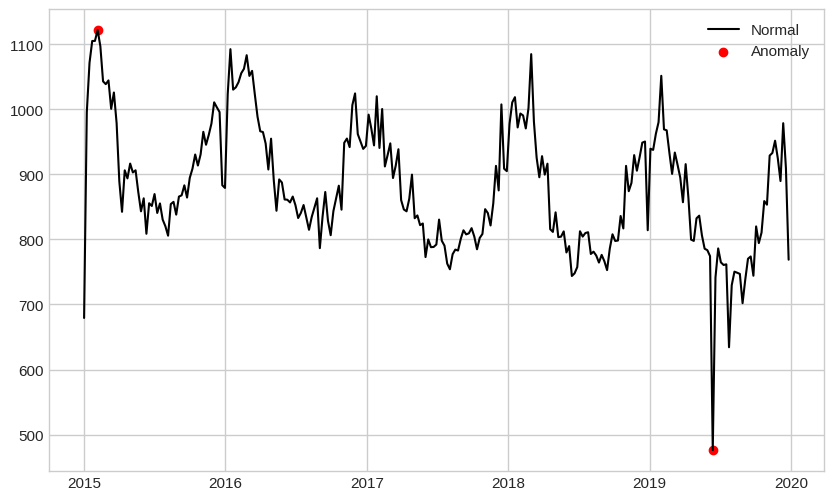

In [ ]:
outliers_fraction = 0.007

model =  IsolationForest(contamination=outliers_fraction)
model.fit(df.Consumption.values.reshape(-1, 1))

df['anomaly_IF'] = model.predict(y)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly_IF'] == -1, ['Consumption']] #anomaly

ax.plot(df.index, df.Consumption, color='black', label = 'Normal')
ax.scatter(a.index,a.Consumption, color='red', label = 'Anomaly')
plt.legend()
plt.show();


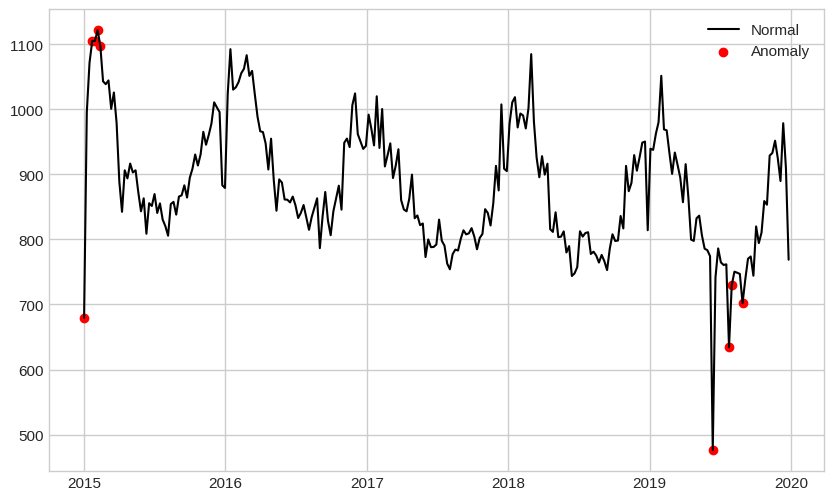

In [ ]:
lof = LocalOutlierFactor(novelty=True)

lof.fit(y)

df['anomaly_LOF'] = lof.predict()


fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly_LOF'] == -1, ['Consumption']] #anomaly

ax.plot(df.index, df['Consumption'], color='black', label = 'Normal')
ax.scatter(a.index,a['Consumption'], color='red', label = 'Anomaly')
plt.legend()
plt.show();


[  1 260] [-1  0]


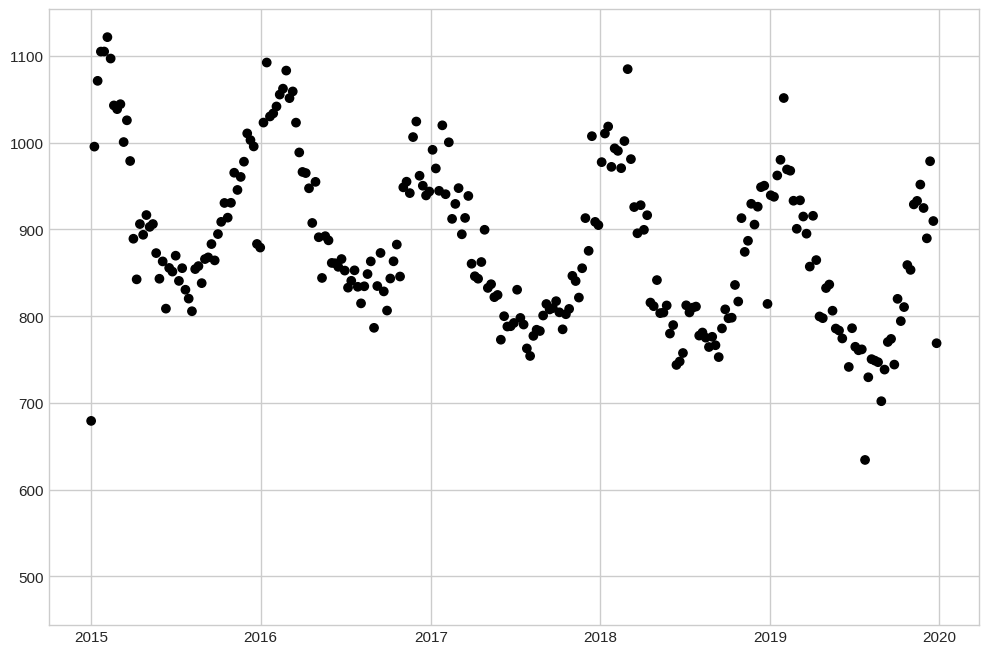

In [ ]:
model=DBSCAN(eps = 100.)
# model = KMeans(n_clusters=10)

model.fit(y)
colors = model.labels_
cls,counts = np.unique(colors, return_counts=True)
sort_idx = np.argsort(counts)#[::-1]
print(counts[sort_idx], cls[sort_idx])
plt.scatter(df.index, y, c = colors == cls[sort_idx][-1])


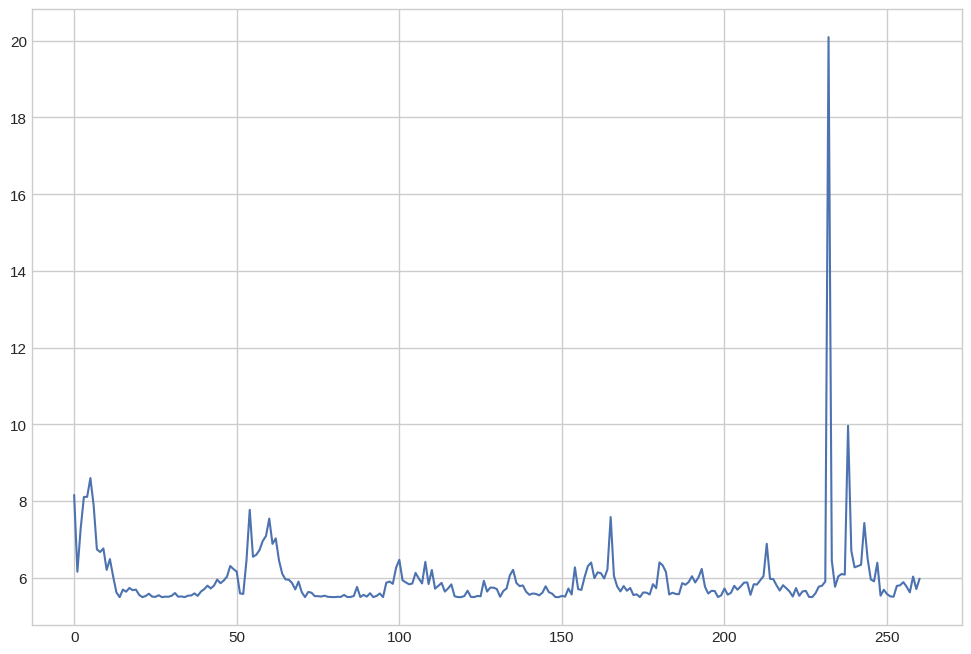

In [ ]:
import pyod.models
from pyod.models.gmm import GMM

clf = GMM( n_components=2, )
clf.fit(y)
y_scores = clf.decision_scores_
plt.plot(y_scores)


## Вывод

К выше сказанную можно добавить, что на данный ВР(общее потребление) влияет не только сезонные погодные условия, праздничные дни и различные источники выработки электроэнергии, но еще и экономические показатели страны, новые технологии (всеобщий переход на энергосберегающие приборы), политические решения и многое другое, поэтому для оценки аномалий необходимо проводить работу по расширению реального признакового пространства учитывающего все выше сказанное

